# Exercise
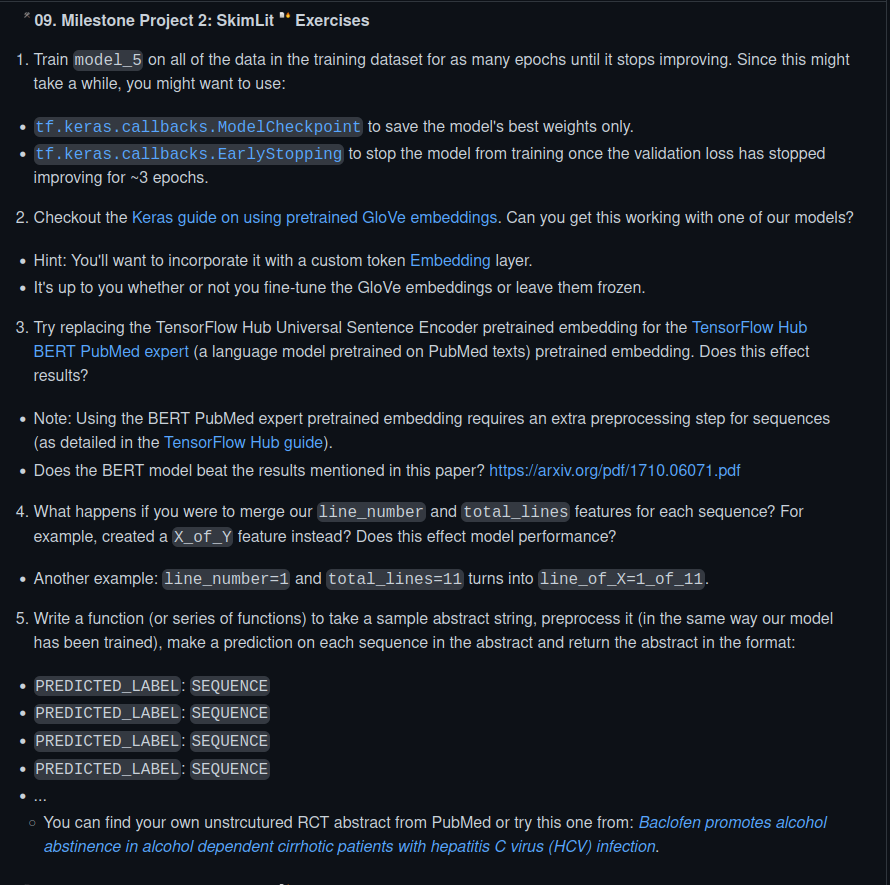


# Extra Resources


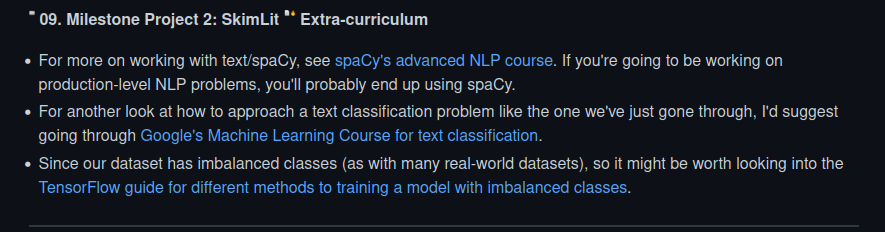

## Helper Functions

In [1]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/helper_functions.py

--2022-09-02 14:10:11--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22463 (22K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  21.94K  --.-KB/s    in 0s      

2022-09-02 14:10:11 (135 MB/s) - ‘helper_functions.py.1’ saved [22463/22463]



In [2]:
from helper_functions import unzip_data, plot_loss_curves, make_confusion_matrix, calculate_results, get_lines, preprocess_text_with_line_numbers

In [3]:
from helper_functions import model_check_point_callback, create_early_stopping_callback, create_tensorboard_callback, reduce_learning_rate_callback

## Inputs

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import random
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding

from tensorflow.keras import mixed_precision

In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e6aa92af-8407-84bb-2836-daa32fe4e2f8)


## Setting up Mixed Precision Training

In [6]:
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [7]:
# mixed_precision.global_policy()

## Getting the data

In [8]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [9]:
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
data_dir

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [10]:
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [11]:
os.listdir(data_dir)

['train.txt', 'dev.txt', 'test.txt']

In [12]:
train_lines= get_lines(filenames[1])
len(train_lines), train_lines[:5]

(35212,
 ['###24290286\n',
  'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
  'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
  'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
  'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n'])

In [13]:
preprocess_text_with_line_numbers(filenames[1])[:5]

[{'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 9},
 {'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 9},
 {'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'line_number': 2,
  'total_lines': 9},
 {'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 3,
  'total_lines': 9},
 {'targe

### Processing the datasets

In [14]:
train_samples= preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples= preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples= preprocess_text_with_line_numbers(data_dir + "test.txt")

In [15]:
train_samples[:1]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11}]

In [16]:
train_df= pd.DataFrame(train_samples)
val_df= pd.DataFrame(val_samples)
test_df= pd.DataFrame(test_samples)

In [17]:
train_df[:11]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [18]:
train_sentences= train_df['text'].tolist()
val_sentences= val_df['text'].tolist()
test_sentences= test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [19]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

### One Hot Encoder labels

In [20]:
one_hot_encoder= OneHotEncoder(sparse=False)

train_labels_one_hot= one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot= one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot= one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot[:5], train_labels_one_hot.shape

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]), (180040, 5))

### Label encode `The target labels` 

> Extract labels `target columns` and encode them into integers. Encoding the `string/text` into `numbers`

In [21]:
label_encoder= LabelEncoder()

train_labels_encoder= label_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_encoder= label_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_encoder= label_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_encoder, train_labels_encoder.shape

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([3, 2, 2, ..., 4, 1, 1]), (180040,))

### Class names and number of classes

In [22]:
num_classes= len(label_encoder.classes_)
class_names= label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [23]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
output_sequence_length= int(np.percentile(sent_lens, 95))
output_sequence_length

55

### Text Vectorizer

In [24]:
max_vocab_length= 68000 # Taken from `Table 2` of the paper
max_length= output_sequence_length

text_vectorizer= TextVectorization(
    max_tokens= max_vocab_length,
    output_sequence_length= max_length
)

text_vectorizer.adapt(train_sentences)

In [25]:
sample_text="I am currently learning doing the exercise of NLP or Natural Language Processing which is a part of Machine Learning."
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[  389,  2651,  1325,   953, 10386,     2,   177,     4,     1,
           16,  2266,  2111,  2573,   126,    20,     8,   732,     4,
         9386,   953,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [26]:
len(text_vectorizer.get_vocabulary())

64841

In [27]:
rct_20K_vocab_length= len(text_vectorizer.get_vocabulary())
rct_20K_vocab_length

64841

In [28]:
max_vocab_length

68000

In [29]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Embedding Layer

In [30]:
embedding= layers.Embedding(input_dim= rct_20K_vocab_length, output_dim= 128, mask_zero= True, name= "token_embedding")

#### Embedding Example

In [31]:
# Show example embedding
print(f"Sentence before vectorization:\n{sample_text}\n")
vectorized_sentence = text_vectorizer([sample_text])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
I am currently learning doing the exercise of NLP or Natural Language Processing which is a part of Machine Learning.

Sentence after vectorization (before embedding):
[[  389  2651  1325   953 10386     2   177     4     1    16  2266  2111
   2573   126    20     8   732     4  9386   953     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.00516956  0.0009887   0.03819818 ... -0.01042033  0.03300314
    0.00951678]
  [ 0.01231322  0.03410504 -0.03298398 ...  0.04537893  0.02817262
    0.00911119]
  [-0.0242993  -0.03715592 -0.01841571 ...  0.00344242  0.02308123
   -0.00371516]
  ...
  [ 0.02836377 -0.02682498  0.00339758 ...  0.03865142 -0.02710759
    0.04658127]
  [ 0.02836377 -0.02682498  0.00339758 ...  0.03865142 -0.02710759
    0.04658127]
  [ 0.02836

## `1` Training the token_character_positional_features_tribrid_embeddings 
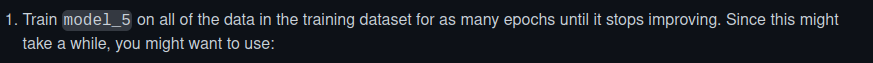

In [32]:
model_url='https://tfhub.dev/google/universal-sentence-encoder/4'

In [33]:
universal_sentence_encoder= hub.KerasLayer(model_url, trainable= False, input_shape=[], dtype="string", name="transfer_learning_USE")

### Character Datasets

In [34]:
def split_sentences(text):
  """
    Function to split text/sentences into characters

  """

  return " ".join(list(text))

In [35]:
train_characters= [split_sentences(sent) for sent in train_sentences]
val_characters= [split_sentences(sent) for sent in val_sentences]
test_characters= [split_sentences(sent) for sent in test_sentences]
train_characters[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [36]:
import string
alphabet= string.ascii_lowercase + string.digits + string.punctuation
len(alphabet), alphabet

(68, 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [37]:
char_lens= [len(sentence) for sentence in train_sentences]
np.percentile(char_lens, 95)

290.0

#### Custom Character level Token Vectorizer

In [38]:
NUM_CHAR_TOKENS= len(alphabet) + 2
output_seq_char_len= int(np.percentile(char_lens, 95))
character_vectorizer= TextVectorization(max_tokens=NUM_CHAR_TOKENS, output_sequence_length= output_seq_char_len, name='character_vectorizer')

character_vectorizer.adapt(train_characters)

In [39]:
random_train_chars = random.choice(train_characters)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = character_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
b i o c h e m i c a l   m a r k e r s   o f   b o n e   r e s o r p t i o n   (   s e r u m   n - t e r m i n a l   t e l o p e p t i d e   a n d   c - t e r m i n a l   t e l o p e p t i d e   )   ,   b o n e   f o r m a t i o n   (   s e r u m   o s t e o c a l c i n   )   ,   a n d   f s h   w e r e   m e a s u r e d   a t   b a s e l i n e   a n d   a f t e r   @   w e e k s   o f   t r e a t m e n t   .

Length of chars: 173

Vectorized chars:
[[22  4  7 11 13  2 15  4 11  5 12 15  5  8 23  2  8  9  7 17 22  7  6  2
   8  2  9  7  8 14  3  4  7  6  9  2  8 16 15  6  3  2  8 15  4  6  5 12
   3  2 12  7 14  2 14  3  4 10  2  5  6 10 11  3  2  8 15  4  6  5 12  3
   2 12  7 14  2 14  3  4 10  2 22  7  6  2 17  7  8 15  5  3  4  7  6  9
   2  8 16 15  7  9  3  2  7 11  5 12 11  4  6  5  6 10 17  9 13 20  2  8
   2 15  2  5  9 16  8  2 10  5  3 22  5  9  2 12  4  6  2  5  6 10  5 17
   3  2  8 20  2  2 23  9  7 17  3  8  2  5  3 15  2  6  3  0  0  0  0  0
   0  0  0  0

### Character Embeddings

In [40]:
character_embedding= layers.Embedding(input_dim= len(character_vectorizer.get_vocabulary()), output_dim=25, mask_zero=True, name="character_embeddings")

In [41]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = character_embedding(character_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
b i o c h e m i c a l   m a r k e r s   o f   b o n e   r e s o r p t i o n   (   s e r u m   n - t e r m i n a l   t e l o p e p t i d e   a n d   c - t e r m i n a l   t e l o p e p t i d e   )   ,   b o n e   f o r m a t i o n   (   s e r u m   o s t e o c a l c i n   )   ,   a n d   f s h   w e r e   m e a s u r e d   a t   b a s e l i n e   a n d   a f t e r   @   w e e k s   o f   t r e a t m e n t   .

Embedded chars (after vectorization and embedding):
[[[-0.04413803  0.01864126  0.0402785  ...  0.0299341   0.02975518
    0.0068249 ]
  [-0.03610392  0.04270745  0.04620811 ...  0.00027175 -0.01657386
    0.00449908]
  [-0.02797792  0.01561913 -0.01723721 ...  0.0473652  -0.04225193
    0.01253005]
  ...
  [ 0.03531459 -0.02854155 -0.00520504 ...  0.02725691  0.04914379
    0.02457568]
  [ 0.03531459 -0.02854155 -0.00520504 ...  0.02725691  0.04914379
    0.02457568]
  [ 0.03531459 -0.02854155 -0.00520504 ...  0.02725691  0.049

### Line Number

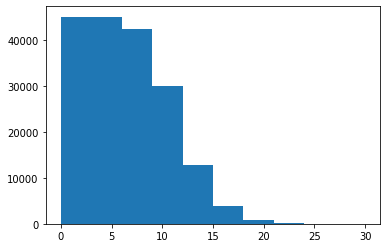

In [42]:
plt.hist(train_df['line_number']);

In [43]:
np.percentile(train_df['line_number'], 98)

15.0

### Line Number dataset

In [44]:
train_df_line_numbers= train_df["line_number"].to_numpy()
val_df_line_numbers= val_df["line_number"].to_numpy()
test_df_line_numbers= test_df["line_number"].to_numpy()

train_df_line_numbers, train_df_line_numbers.shape

(array([ 0,  1,  2, ...,  9, 10, 11]), (180040,))

In [45]:
train_df_line_numbers.dtype

dtype('int64')

### One Hot Encoded Line Number dataset

In [46]:
train_line_numbers_one_hot= tf.one_hot(train_df_line_numbers, depth=15)
val_line_numbers_one_hot= tf.one_hot(val_df_line_numbers, depth=15)
test_line_numbers_one_hot= tf.one_hot(test_df_line_numbers, depth=15)

train_line_numbers_one_hot, train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 15]))

### Total Lines

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 3. ,  5.7,  8.4, 11.1, 13.8, 16.5, 19.2, 21.9, 24.6, 27.3, 30. ]),
 <a list of 10 Patch objects>)

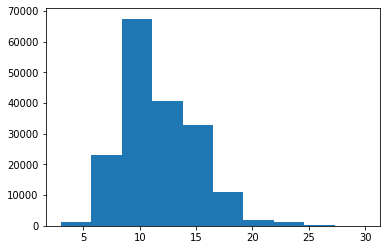

In [47]:
plt.hist(train_df['total_lines'])

In [48]:
np.percentile(train_df['total_lines'], 98)

20.0

### Total Lines dataset

In [49]:
train_df_total_lines= train_df["total_lines"].to_numpy()
val_df_total_lines= val_df["total_lines"].to_numpy()
test_df_total_lines= test_df["total_lines"].to_numpy()

train_df_total_lines, train_df_total_lines.shape

(array([11, 11, 11, ..., 11, 11, 11]), (180040,))

### One Hot Encoded Total Lines dataset

In [50]:
train_total_lines_one_hot= tf.one_hot(train_df_total_lines, depth=20)
val_total_lines_one_hot= tf.one_hot(val_df_total_lines, depth=20)
test_total_lines_one_hot= tf.one_hot(test_df_total_lines, depth=20)

train_total_lines_one_hot, train_total_lines_one_hot.shape

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]))

## Building the `Tribrid Embedding model with the whole training dataset`

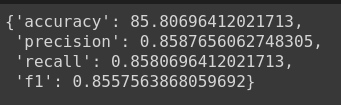

### `1` Token Inputs

In [51]:
token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= universal_sentence_encoder(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)

token_model= tf.keras.Model(token_inputs, token_outputs, name="token_model")

### `2` Character Inputs

In [52]:
character_inputs= layers.Input(shape=(1, ), dtype="string", name="character_inputs")
character_vectors= character_vectorizer(character_inputs)
character_embeddings= character_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm, name="character_model")

### `3` Line Number Model

In [ ]:
line_number_inputs= layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer, name= "line_number_model")

### `4` Total Lines Model

In [ ]:
total_lines_input= layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model= tf.keras.Model(total_lines_input, dense_layer, name="total_lines_model")

### `5` Combine Token and character Embeddings

In [ ]:
combine_embeddings= layers.Concatenate(name="token_and_character_embeddings")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combine_embeddings)
x= layers.Dropout(0.5, name="dropout_layer")(dense_layer)

### `6` Combine the positional embeddings with the `combine_embeddings` above i.e with `token and character embeddings`

In [ ]:
tribrid_embeddings= layers.Concatenate(name="positional_features_with_token_and_character_embeddings")([line_number_model.output, total_lines_model.output, x])

### `7` Output layer for `Tribrid` model

In [ ]:
output_layer= layers.Dense(num_classes, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

### `8` Putting the model together

In [ ]:
tribrid_model_whole= tf.keras.Model(inputs= [line_number_model.inputs, total_lines_model.input, token_model.input, character_model.input], outputs=output_layer, name="tribrid_embedding_model_5")

In [ ]:
tribrid_model_whole.summary()

Model: "tribrid_embedding_model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_inputs[0][0]']       
 orization)                                                                                       
                                                                                                  
 transfer_learning_USE (KerasLa  (None, 512)         256797824   ['token_i

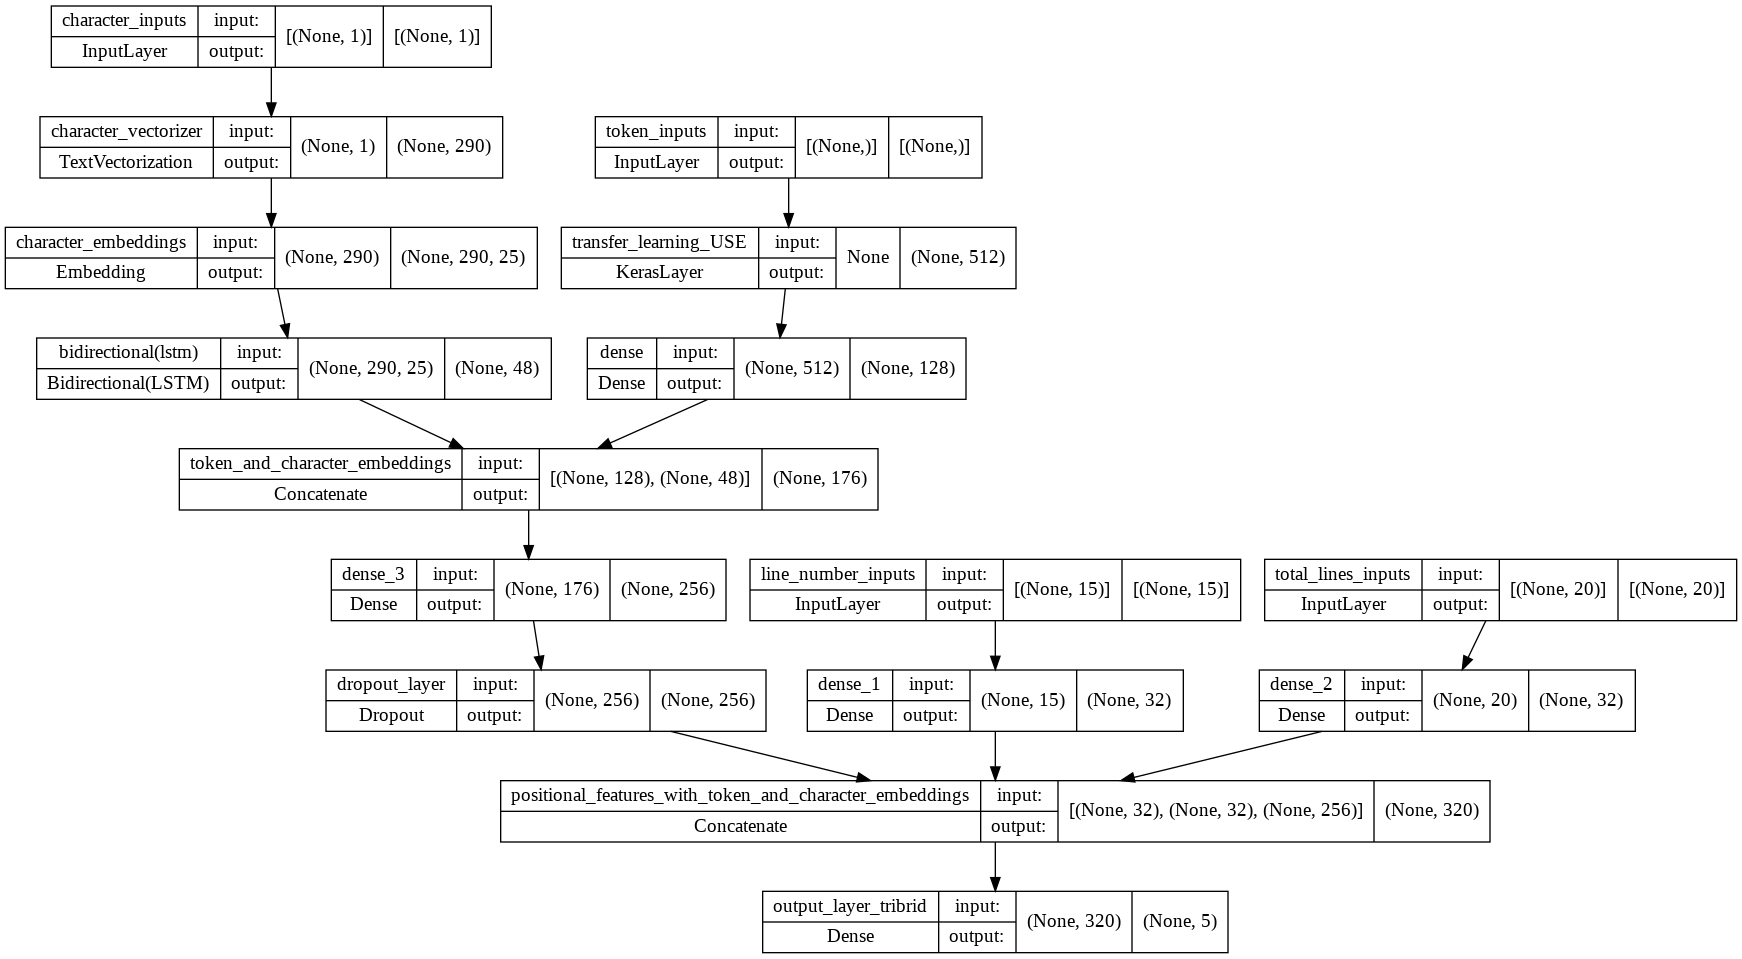

In [ ]:
plot_model(tribrid_model_whole, show_shapes=True)

In [ ]:
tribrid_model_whole.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

### Making datasets performant and load faster

In [ ]:
train_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_characters)) # Data
train_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # Labels
train_line_total_token_char_dataset= tf.data.Dataset.zip((train_line_total_token_char_data, train_line_total_token_char_labels)) # Combining data and labels

train_line_total_token_char_dataset= train_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_characters))
val_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(val_labels_one_hot) 
val_line_total_token_char_dataset= tf.data.Dataset.zip((val_line_total_token_char_data, val_line_total_token_char_labels)) 

val_line_total_token_char_dataset= val_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


test_line_total_token_char_data= tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_characters))
test_line_total_token_char_labels= tf.data.Dataset.from_tensor_slices(test_labels_one_hot) 
test_line_total_token_char_dataset= tf.data.Dataset.zip((test_line_total_token_char_data, test_line_total_token_char_labels)) 

test_line_total_token_char_dataset= test_line_total_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



train_line_total_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Creating some useful callbacks For Feature Extractor Model

In [ ]:
model_checkpoint_path= 'checkpoints'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="tribrid_embeddings_with_whole_training_dataset")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/tribrid_embeddings_with_whole_training_dataset/20220901-112505


### Training the model with `trainable=False` in the pre-trained USE feature extractor model

In [ ]:
# history_tribrid_model_whole= tribrid_model_whole.fit(train_line_total_token_char_dataset, epochs=10, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.8204
Epoch 1: val_accuracy improved from -inf to 0.84837, saving model to checkpoints
5627/5627 [==============================] - 294s 50ms/step - loss: 0.9567 - accuracy: 0.8204 - val_loss: 0.9090 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9096 - accuracy: 0.8532
Epoch 2: val_accuracy improved from 0.84837 to 0.85284, saving model to checkpoints
5627/5627 [==============================] - 276s 49ms/step - loss: 0.9096 - accuracy: 0.8532 - val_loss: 0.8997 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.8626
Epoch 3: val_accuracy did not improve from 0.85284
5627/5627 [==============================] - 272s 48ms/step - loss: 0.8971 - accuracy: 0.8626 - val_loss: 0.9011 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 4/10
5627/5627 [=====================

## Evaluating the model

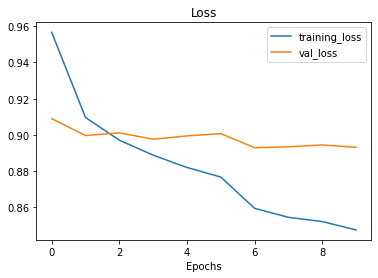

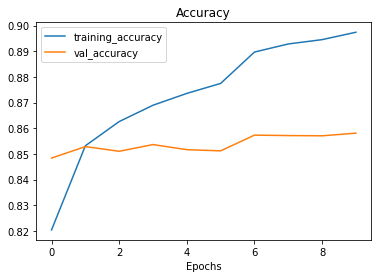

In [ ]:
# plot_loss_curves(history_tribrid_model_whole)

In [ ]:
# tribrid_model_whole_evaluate=tribrid_model_whole.evaluate(val_line_total_token_char_dataset)
# tribrid_model_whole_evaluate

945/945 [==============================] - 22s 23ms/step - loss: 0.8932 - accuracy: 0.8581


[0.8931522369384766, 0.858069658279419]

In [ ]:
# tribrid_model_whole_pred_probs= tribrid_model_whole.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_pred_probs

array([[0.681933  , 0.08759124, 0.01794036, 0.18799558, 0.02453988],
       [0.6070949 , 0.0957007 , 0.03914917, 0.23690814, 0.0211471 ],
       [0.330632  , 0.05893952, 0.02247716, 0.57041824, 0.01753303],
       ...,
       [0.02849247, 0.07224851, 0.0239806 , 0.03367176, 0.8416066 ],
       [0.02282009, 0.4247516 , 0.15586968, 0.03147404, 0.36508462],
       [0.05792545, 0.89015394, 0.01927612, 0.02038916, 0.01225542]],
      dtype=float32)

In [ ]:
# tribrid_model_whole_preds= tf.argmax(tribrid_model_whole_pred_probs, axis=1)
# tribrid_model_whole_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# tribrid_model_whole_results= calculate_results(val_labels_encoder, tribrid_model_whole_preds)
# tribrid_model_whole_results

{'accuracy': 85.80696412021713,
 'precision': 0.8587656062748305,
 'recall': 0.8580696412021713,
 'f1': 0.8557563868059692}

## Conclusion

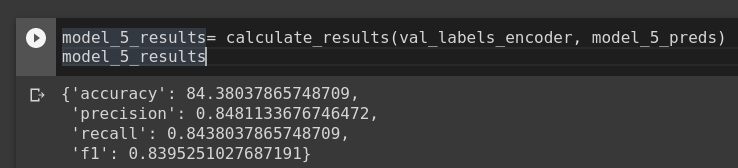

> This is the score the same model got when trained on `10%` of the dataset at every epoch of the model training. The model ran for `5` epochs only.

### Training the model with `trainable=True` as a Fine-Tuned model. The layers of the USE model are unfrozen.

In [ ]:
universal_sentence_encoder_trainable= hub.KerasLayer(model_url, trainable= True, input_shape=[], dtype="string", name="transfer_learning_USE_fine_tuned")

In [ ]:
# Token Embeddings

token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= universal_sentence_encoder_trainable(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)

token_model= tf.keras.Model(token_inputs, token_outputs, name="token_model")

# Character Embeddings

character_inputs= layers.Input(shape=(1, ), dtype="string", name="character_inputs")
character_vectors= character_vectorizer(character_inputs)
character_embeddings= character_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm, name="character_model")

# Line Number feature

line_number_inputs= layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer, name= "line_number_model")

# Total Lines Feature

total_lines_input= layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model= tf.keras.Model(total_lines_input, dense_layer, name="total_lines_model")

# Combining Token and Character Embeddings

combine_embeddings= layers.Concatenate(name="token_and_character_embeddings")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combine_embeddings)
x= layers.Dropout(0.5, name="dropout_layer")(dense_layer)

# Combining the Engineered features(Line Number and Total Lines) with the token and character embeddings

tribrid_embeddings= layers.Concatenate(name="positional_features_with_token_and_character_embeddings_with_fine_tuning")([line_number_model.output, total_lines_model.output, x])

# Output layer of the Tribrid Model

output_layer= layers.Dense(num_classes, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

# Putting the model together

tribrid_model_whole_fine_tuned= tf.keras.Model(inputs= [line_number_model.inputs, total_lines_model.input, token_model.input, character_model.input], outputs=output_layer, name="tribrid_embedding_fine_tuned_model")

In [ ]:
tribrid_model_whole_fine_tuned.summary()

Model: "tribrid_embedding_fine_tuned_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_inputs[0][0]']       
 orization)                                                                                       
                                                                                                  
 transfer_learning_USE_fine_tun  (None, 512)         256797824   

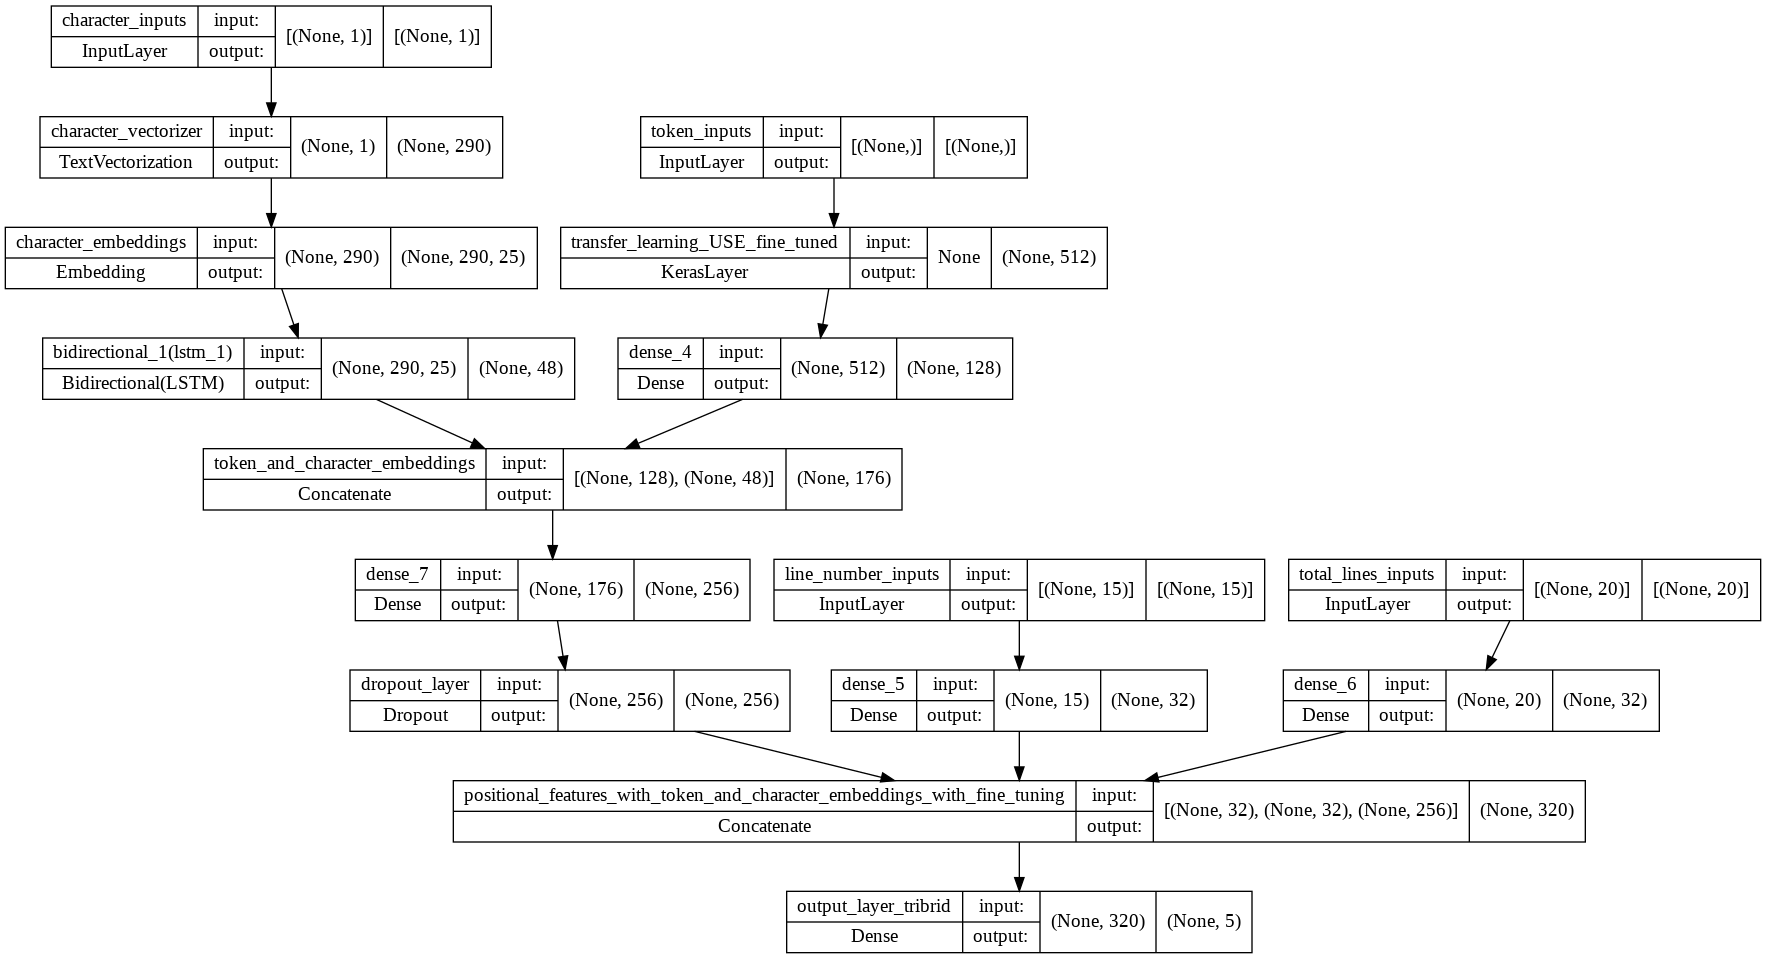

In [ ]:
plot_model(tribrid_model_whole_fine_tuned, show_shapes=True)

In [ ]:
tribrid_model_whole_fine_tuned.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

### Callbacks for Fine-Tuned Model

In [ ]:
model_checkpoint_path= 'checkpoints_fine_tuned'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="tribrid_embeddings_with_whole_training_dataset_with_fine_tuning")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/tribrid_embeddings_with_whole_training_dataset_with_fine_tuning/20220901-112655


In [ ]:
# history_tribrid_model_whole_fine_tuned= tribrid_model_whole_fine_tuned.fit(train_line_total_token_char_dataset, epochs=10, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9045 - accuracy: 0.8529
Epoch 1: val_accuracy improved from -inf to 0.87442, saving model to checkpoints_fine_tuned
5627/5627 [==============================] - 1076s 188ms/step - loss: 0.9045 - accuracy: 0.8529 - val_loss: 0.8673 - val_accuracy: 0.8744 - lr: 0.0010
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 0.7835 - accuracy: 0.9347
Epoch 2: val_accuracy did not improve from 0.87442
5627/5627 [==============================] - 1043s 185ms/step - loss: 0.7835 - accuracy: 0.9347 - val_loss: 0.8997 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.9751
Epoch 3: val_accuracy did not improve from 0.87442

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5627/5627 [==============================] - 1042s 185ms/step - loss: 0.7197 - accuracy: 0.9751 - val_loss: 0.9198 - val_accuracy: 0

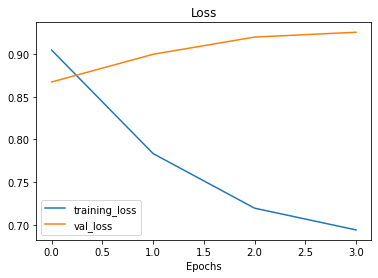

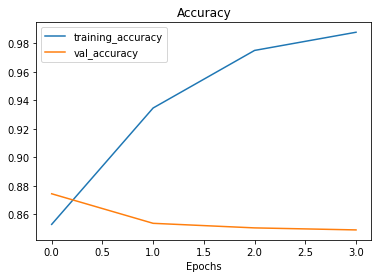

In [ ]:
plot_loss_curves(history_tribrid_model_whole_fine_tuned)

In [ ]:
# tribrid_model_whole_fine_tuned_pred_probs= tribrid_model_whole_fine_tuned.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_fine_tuned_preds= tf.argmax(tribrid_model_whole_fine_tuned_pred_probs, axis=1)
# tribrid_model_whole_fine_tuned_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 1, 1])>

In [ ]:
# tribrid_model_whole_fine_tuned_results= calculate_results(val_labels_encoder, tribrid_model_whole_fine_tuned_preds)
# tribrid_model_whole_fine_tuned_results

In [ ]:
# tribrid_model_whole_results

NameError: ignored

## The `optimizer` used in the paper was `SGD()` and I used `Adam()` instead as it was reliable and I was using it from the start.

> Let's try SGD() optimizer instead of Adam() and see if the score of the model improves or not. Using the `Fine-Tuned` model, with `trainable=True`.

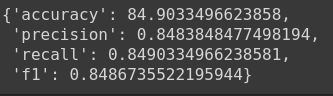

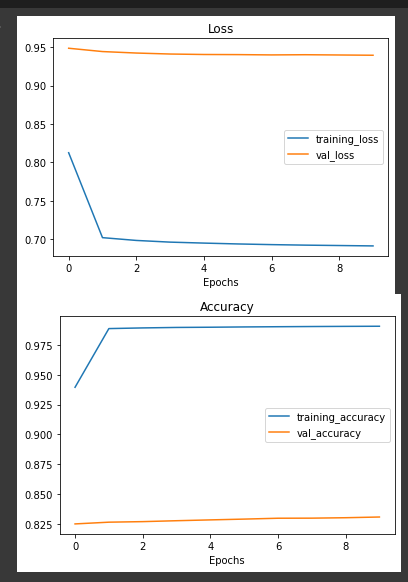

In [ ]:
# Token Embeddings

token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= universal_sentence_encoder_trainable(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)

token_model= tf.keras.Model(token_inputs, token_outputs, name="token_model")

# Character Embeddings

character_inputs= layers.Input(shape=(1, ), dtype="string", name="character_inputs")
character_vectors= character_vectorizer(character_inputs)
character_embeddings= character_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm, name="character_model")

# Line Number feature

line_number_inputs= layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer, name= "line_number_model")

# Total Lines Feature

total_lines_input= layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model= tf.keras.Model(total_lines_input, dense_layer, name="total_lines_model")

# Combining Token and Character Embeddings

combine_embeddings= layers.Concatenate(name="token_and_character_embeddings")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combine_embeddings)
x= layers.Dropout(0.5, name="dropout_layer")(dense_layer)

# Combining the Engineered features(Line Number and Total Lines) with the token and character embeddings

tribrid_embeddings= layers.Concatenate(name="positional_features_with_token_and_character_embeddings_with_fine_tuning_using_sgd")([line_number_model.output, total_lines_model.output, x])

# Output layer of the Tribrid Model

output_layer= layers.Dense(num_classes, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

# Putting the model together

tribrid_model_whole_fine_tuned_using_sgd= tf.keras.Model(inputs= [line_number_model.inputs, total_lines_model.input, token_model.input, character_model.input], outputs=output_layer, name="tribrid_embedding_fine_tuned_model_using_sgd")

In [ ]:
tribrid_model_whole_fine_tuned_using_sgd.summary()

Model: "tribrid_embedding_fine_tuned_model_using_sgd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_inputs[0][0]']       
 orization)                                                                                       
                                                                                                  
 transfer_learning_USE_fine_tun  (None, 512)         25

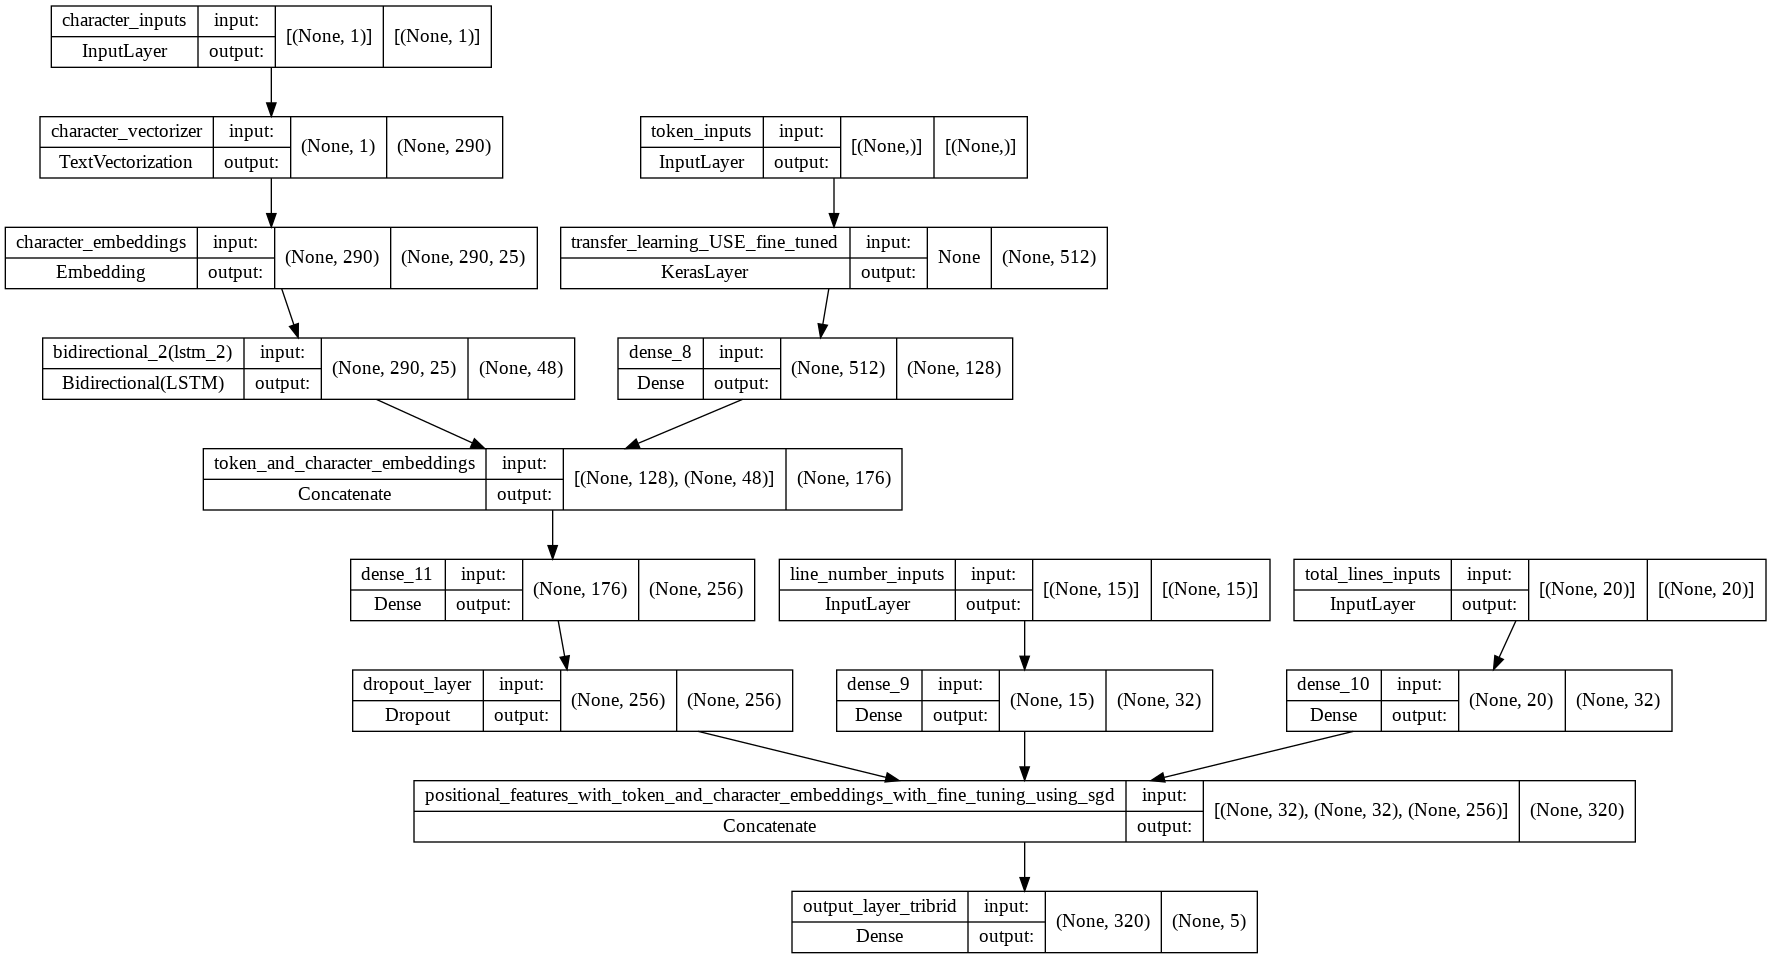

In [ ]:
plot_model(tribrid_model_whole_fine_tuned_using_sgd, show_shapes=True)

In [ ]:
tribrid_model_whole_fine_tuned_using_sgd.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.SGD(), metrics=["accuracy"])

### Callbacks for Fine-Tuned model using `SGD()` optimizer

In [ ]:
model_checkpoint_path= 'checkpoints_fine_tuned_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="tribrid_embeddings_with_whole_training_dataset_with_fine_tuning_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/tribrid_embeddings_with_whole_training_dataset_with_fine_tuning_using_sgd/20220901-112750


In [ ]:
# history_tribrid_model_whole_fine_tuned_using_sgd= tribrid_model_whole_fine_tuned_using_sgd.fit(train_line_total_token_char_dataset, epochs=10, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.8126 - accuracy: 0.9395
Epoch 1: val_accuracy improved from -inf to 0.82484, saving model to checkpoints_fine_tuned_using_sgd
5627/5627 [==============================] - 299s 52ms/step - loss: 0.8126 - accuracy: 0.9395 - val_loss: 0.9486 - val_accuracy: 0.8248 - lr: 0.0100
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.9887
Epoch 2: val_accuracy improved from 0.82484 to 0.82629, saving model to checkpoints_fine_tuned_using_sgd
5627/5627 [==============================] - 288s 51ms/step - loss: 0.7020 - accuracy: 0.9887 - val_loss: 0.9443 - val_accuracy: 0.8263 - lr: 0.0100
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.9893
Epoch 3: val_accuracy improved from 0.82629 to 0.82676, saving model to checkpoints_fine_tuned_using_sgd
5627/5627 [==============================] - 288s 51ms/step - loss: 0.6984 - accuracy: 0.9893 - 

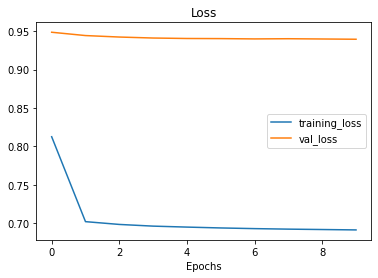

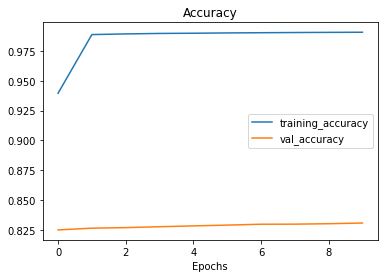

In [ ]:
# plot_loss_curves(history_tribrid_model_whole_fine_tuned_using_sgd)

In [ ]:
# tribrid_model_whole_fine_tuned_using_sgd_pred_probs= tribrid_model_whole_fine_tuned_using_sgd.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_fine_tuned_using_sgd_preds= tf.argmax(tribrid_model_whole_fine_tuned_using_sgd_pred_probs, axis=1)
# tribrid_model_whole_fine_tuned_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 1, 1])>

In [ ]:
# tribrid_model_whole_fine_tuned_using_sgd_results= calculate_results(tribrid_model_whole_fine_tuned_using_sgd_preds, val_labels_encoder)
# tribrid_model_whole_fine_tuned_using_sgd_results

{'accuracy': 83.06302131603337,
 'precision': 0.8324775869117791,
 'recall': 0.8306302131603337,
 'f1': 0.8314538505220812}

In [ ]:
# tribrid_model_whole_results

NameError: ignored

In [ ]:
# tribrid_model_whole_fine_tuned_results

{'accuracy': 84.9033496623858,
 'precision': 0.8483848477498194,
 'recall': 0.8490334966238581,
 'f1': 0.8486735522195944}

## The `optimizer` used in the paper was `SGD()` and I used `Adam()` instead as it was reliable and I was using it from the start.

> Let's try SGD() optimizer instead of Adam() and see if the score of the model improves or not. Using the `Feature Extractor` model, with `trainable=False`.


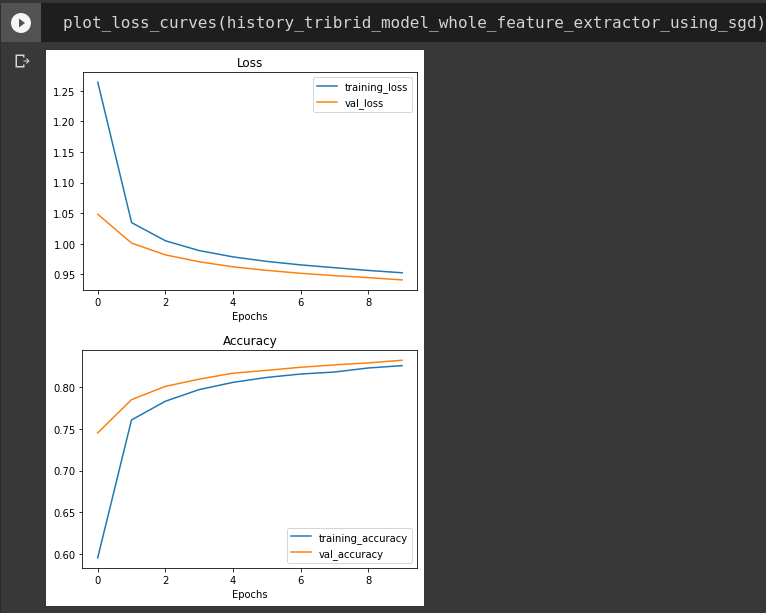

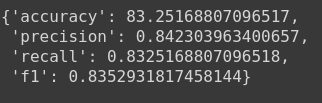

In [ ]:
universal_sentence_encoder= hub.KerasLayer(model_url, trainable= False, input_shape=[], dtype="string", name="transfer_learning_USE")

In [ ]:
# Token Embeddings

token_inputs= layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings= universal_sentence_encoder(token_inputs)
token_outputs= layers.Dense(128, activation="relu")(token_embeddings)

token_model= tf.keras.Model(token_inputs, token_outputs, name="token_model")

# Character Embeddings

character_inputs= layers.Input(shape=(1, ), dtype="string", name="character_inputs")
character_vectors= character_vectorizer(character_inputs)
character_embeddings= character_embedding(character_vectors)
character_bi_lstm= layers.Bidirectional(layers.LSTM(24))(character_embeddings)
character_model= tf.keras.Model(character_inputs, character_bi_lstm, name="character_model")

# Line Number feature

line_number_inputs= layers.Input(shape=(15,), dtype="float32", name="line_number_inputs")
dense_layer= layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs, dense_layer, name= "line_number_model")

# Total Lines Feature

total_lines_input= layers.Input(shape=(20,), dtype="float32", name="total_lines_inputs")
dense_layer= layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model= tf.keras.Model(total_lines_input, dense_layer, name="total_lines_model")

# Combining Token and Character Embeddings

combine_embeddings= layers.Concatenate(name="token_and_character_embeddings")([token_model.output, character_model.output])

dense_layer= layers.Dense(256, activation="relu")(combine_embeddings)
x= layers.Dropout(0.5, name="dropout_layer")(dense_layer)

# Combining the Engineered features(Line Number and Total Lines) with the token and character embeddings

tribrid_embeddings= layers.Concatenate(name="positional_features_with_token_and_character_embeddings_with_feature_extraction_using_sgd")([line_number_model.output, total_lines_model.output, x])

# Output layer of the Tribrid Model

output_layer= layers.Dense(num_classes, activation="softmax", name="output_layer_tribrid")(tribrid_embeddings)

# Putting the model together

tribrid_model_whole_feature_extractor_using_sgd= tf.keras.Model(inputs= [line_number_model.inputs, total_lines_model.input, token_model.input, character_model.input], outputs=output_layer, name="tribrid_embedding_feature_extractor_using_sgd")

In [ ]:
tribrid_model_whole_feature_extractor_using_sgd.summary()

Model: "tribrid_embedding_feature_extractor_using_sgd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 character_inputs (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 character_vectorizer (TextVect  (None, 290)         0           ['character_inputs[0][0]']       
 orization)                                                                                       
                                                                                                  
 transfer_learning_USE (KerasLa  (None, 512)         2

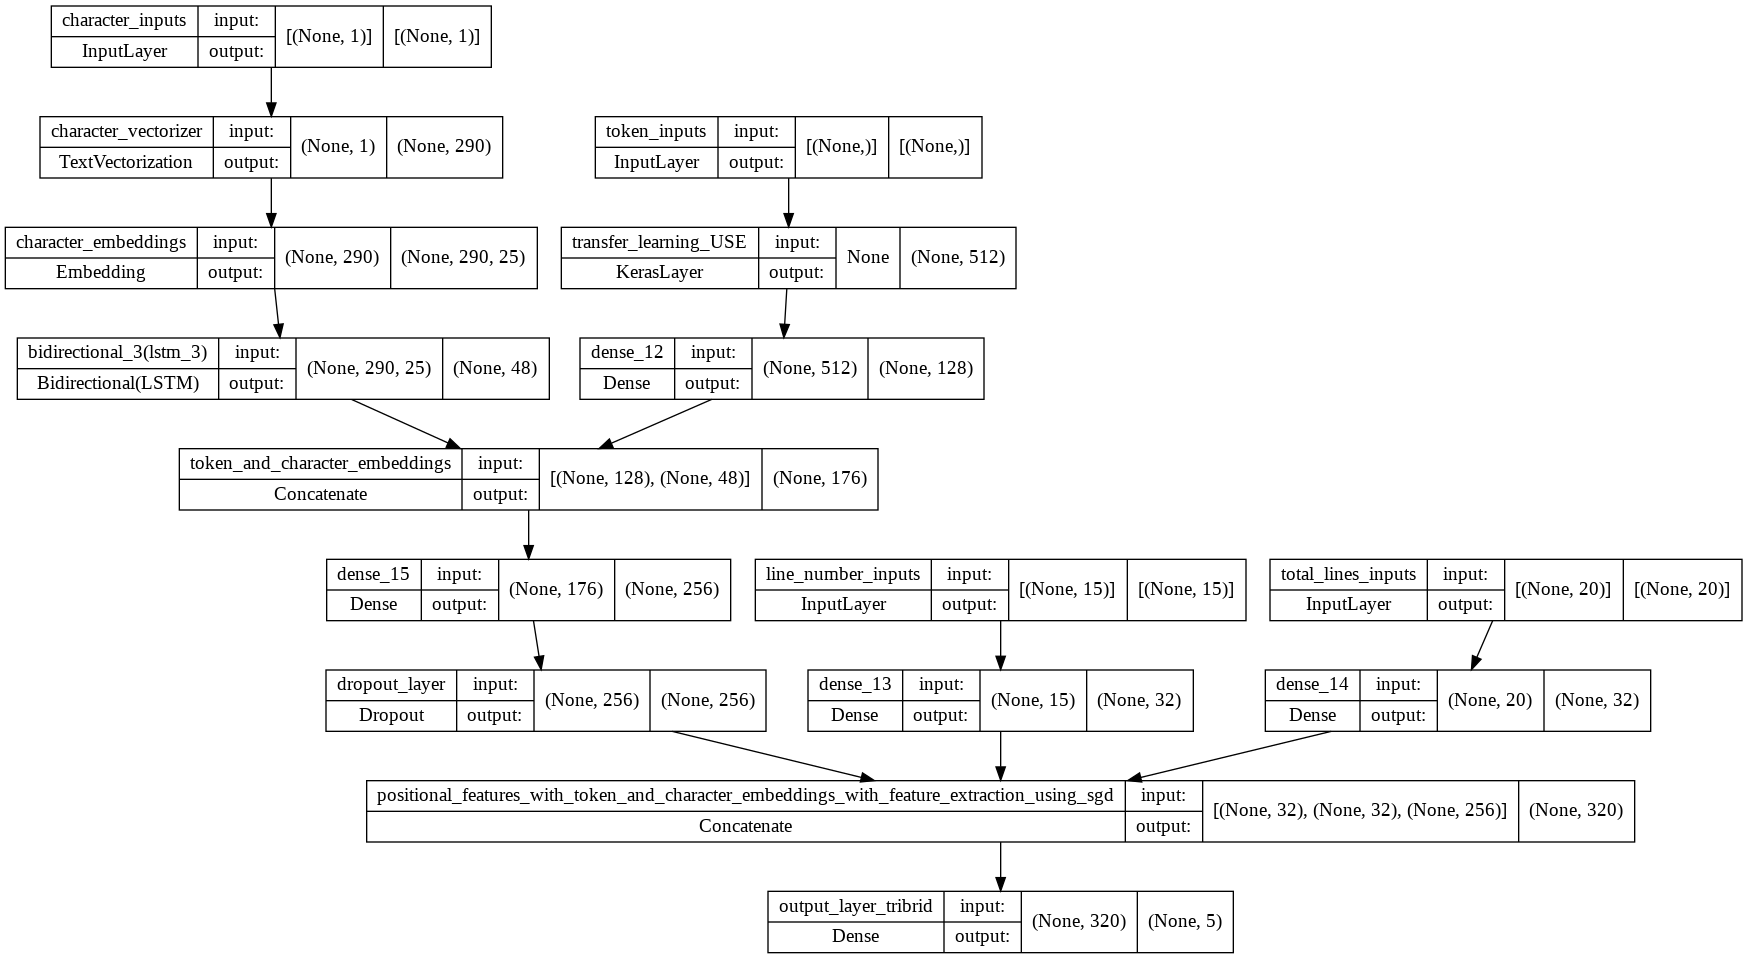

In [ ]:
plot_model(tribrid_model_whole_feature_extractor_using_sgd, show_shapes=True)

In [ ]:
tribrid_model_whole_feature_extractor_using_sgd.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer= tf.keras.optimizers.SGD(), metrics=["accuracy"])

### Callbacks for Feature extractor model using SGD()

In [ ]:
model_checkpoint_path= 'checkpoints_feature_extractor_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="tribrid_embeddings_with_whole_training_dataset_with_feature_extractor_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/tribrid_embeddings_with_whole_training_dataset_with_feature_extractor_using_sgd/20220901-112924


In [ ]:
# history_tribrid_model_whole_feature_extractor_using_sgd= tribrid_model_whole_feature_extractor_using_sgd.fit(train_line_total_token_char_dataset, epochs=10, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 1.2639 - accuracy: 0.5951
Epoch 1: val_accuracy improved from -inf to 0.74520, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 267s 46ms/step - loss: 1.2639 - accuracy: 0.5951 - val_loss: 1.0482 - val_accuracy: 0.7452 - lr: 0.0100
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 1.0345 - accuracy: 0.7608
Epoch 2: val_accuracy improved from 0.74520 to 0.78518, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 260s 46ms/step - loss: 1.0345 - accuracy: 0.7608 - val_loss: 1.0010 - val_accuracy: 0.7852 - lr: 0.0100
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 1.0048 - accuracy: 0.7833
Epoch 3: val_accuracy improved from 0.78518 to 0.80111, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 258s 46ms/step - loss: 1.0048 

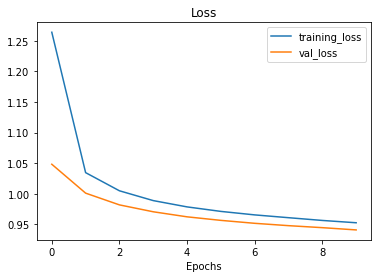

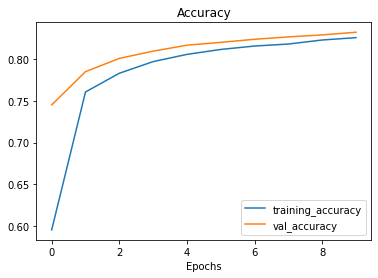

In [ ]:
# plot_loss_curves(history_tribrid_model_whole_feature_extractor_using_sgd)

In [ ]:
# tribrid_model_whole_feature_extractor_using_sgd_pred_probs= tribrid_model_whole_feature_extractor_using_sgd.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_feature_extractor_using_sgd_preds= tf.argmax(tribrid_model_whole_feature_extractor_using_sgd_pred_probs, axis=1)
# tribrid_model_whole_feature_extractor_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# tribrid_model_whole_feature_extractor_using_sgd_results= calculate_results(tribrid_model_whole_feature_extractor_using_sgd_preds, val_labels_encoder)
# tribrid_model_whole_feature_extractor_using_sgd_results

{'accuracy': 83.25168807096517,
 'precision': 0.842303963400657,
 'recall': 0.8325168807096518,
 'f1': 0.8352931817458144}

## Same Model(`tribrid_model_whole_feature_extractor_using_sgd`) as above but trained for longer, `epochs=20`

### Results

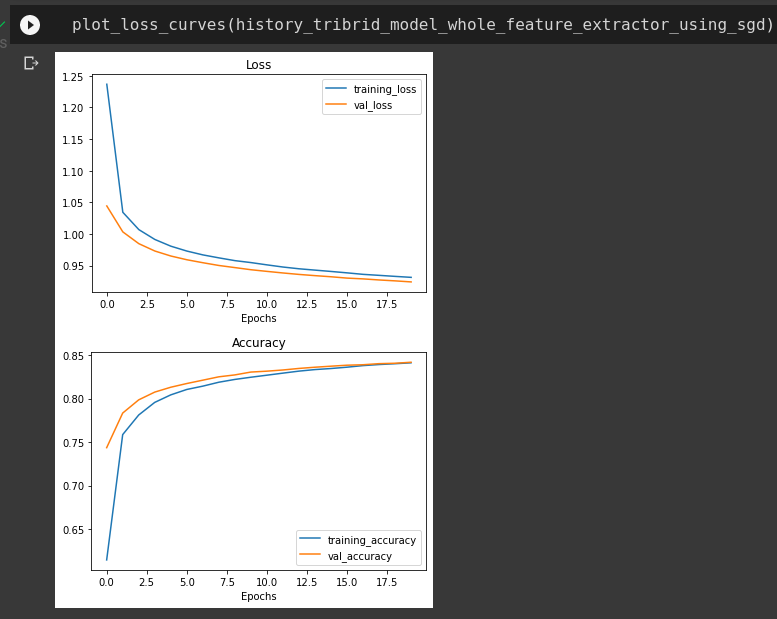

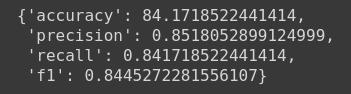


In [ ]:
# history_tribrid_model_whole_feature_extractor_using_sgd= tribrid_model_whole_feature_extractor_using_sgd.fit(train_line_total_token_char_dataset, epochs=20, steps_per_epoch=len(train_line_total_token_char_dataset), validation_data=val_line_total_token_char_dataset, validation_steps=len(val_line_total_token_char_dataset), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/20
5627/5627 [==============================] - ETA: 0s - loss: 1.2367 - accuracy: 0.6145
Epoch 1: val_accuracy improved from -inf to 0.74351, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 280s 47ms/step - loss: 1.2367 - accuracy: 0.6145 - val_loss: 1.0443 - val_accuracy: 0.7435 - lr: 0.0100
Epoch 2/20
5627/5627 [==============================] - ETA: 0s - loss: 1.0343 - accuracy: 0.7585
Epoch 2: val_accuracy improved from 0.74351 to 0.78330, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 265s 47ms/step - loss: 1.0343 - accuracy: 0.7585 - val_loss: 1.0033 - val_accuracy: 0.7833 - lr: 0.0100
Epoch 3/20
5627/5627 [==============================] - ETA: 0s - loss: 1.0069 - accuracy: 0.7811
Epoch 3: val_accuracy improved from 0.78330 to 0.79849, saving model to checkpoints_feature_extractor_using_sgd
5627/5627 [==============================] - 260s 46ms/step - loss: 1.0069 

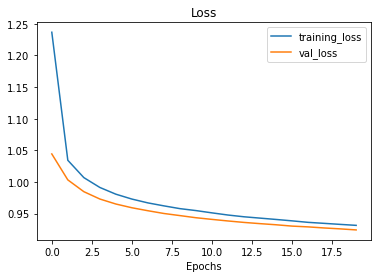

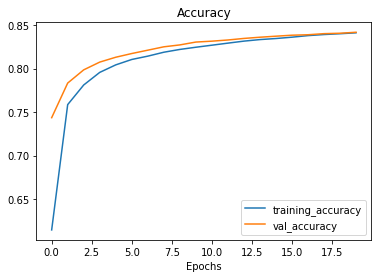

In [ ]:
# plot_loss_curves(history_tribrid_model_whole_feature_extractor_using_sgd)

In [ ]:
# tribrid_model_whole_feature_extractor_using_sgd_pred_probs= tribrid_model_whole_feature_extractor_using_sgd.predict(val_line_total_token_char_dataset)
# tribrid_model_whole_feature_extractor_using_sgd_preds= tf.argmax(tribrid_model_whole_feature_extractor_using_sgd_pred_probs, axis=1)
# tribrid_model_whole_feature_extractor_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# tribrid_model_whole_feature_extractor_using_sgd_results= calculate_results(tribrid_model_whole_feature_extractor_using_sgd_preds, val_labels_encoder)
# tribrid_model_whole_feature_extractor_using_sgd_results

{'accuracy': 84.1718522441414,
 'precision': 0.8518052899124999,
 'recall': 0.841718522441414,
 'f1': 0.8445272281556107}

## Pre-trained `Glove Embeddings`

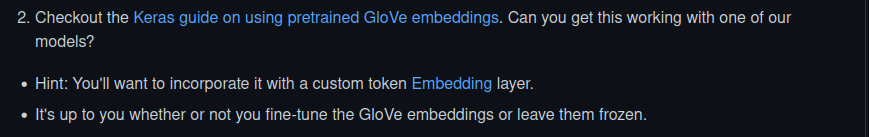

### Getting the Pre-trained `Glove Embeddings`

* Link -> https://keras.io/examples/nlp/pretrained_word_embeddings/

In [114]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

unzip_data('glove.6B.zip')

--2022-09-02 07:12:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-02 07:12:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-02 07:12:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

### Getting the paths of the glove embeddings

In [115]:
glove_path= 'glove.6B.100d.txt'

embedding_index={}

# Making a dictionary representation of the words(s -> [8,48...])

with open(glove_path) as f:
  for line in f:
    # Getting the words and coeffecients of the variable
    word, coefs= line.split(maxsplit=1)
    coefs= np.fromstring(coefs, 'f', sep=' ')

    # Adding the coeffecient to the embedding dict
    embedding_index[word]= coefs

len(embedding_index)

400000

### Getting the sentences and characters

In [116]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [117]:
np.percentile(len(train_df['text']), 95)

180040.0

In [118]:
train_sentences= train_df['text'].tolist()
val_sentences= val_df['text'].tolist()

In [119]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [120]:
train_chars= [split_sentences(sentence) for sentence in train_sentences]
val_chars= [split_sentences(sentence) for sentence in val_sentences]

In [121]:
char_lens= [len(sentence) for sentence in train_sentences]
np.percentile(char_lens, 95)

290.0

In [122]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [123]:
text_vectorizer.adapt(train_sentences)

In [124]:
text_vocab= text_vectorizer.get_vocabulary()
len(text_vocab)

64841

### Getting the dict mapping word --> index 

In [125]:
word_index_text = dict(zip(text_vocab , range(len(text_vocab))))

### Creating a function that will give us a embedding matrix 

In [126]:
def get_glove_embedding_matrix(num_tokens , embedding_dim , word_index):

  # Defining the hits and misses here 
  hits , misses = 0 , 0

  # Prepare the embedding matrix 
  embedding_matrix = np.zeros((num_tokens , embedding_dim ))
  for word , i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector 
      hits += 1 
    else:
      misses += 1 

  return embedding_matrix , hits , misses

### Embedding matrix

In [127]:
num_tokens_text = len(text_vocab) + 2 
embedding_dim = 100
sentence_embedding_matrix , hits_ , misses_ = get_glove_embedding_matrix(num_tokens_text , embedding_dim, word_index_text)

print(f'Hits: {hits_} and Misses: {misses_} for the sentence embedding matrix')

Hits: 29730 and Misses: 35111 for the sentence embedding matrix


### Adding the embedding matrix to our Embedding layer (Sentence and characters)

In [128]:
sen_embedding_layer = Embedding(num_tokens_text , 
                            embedding_dim , 
                            embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , 
                            trainable = False )

### Datasets for both sentences and characters

In [129]:
train_sen_vectors = text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy()
val_sen_vectors = text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

In [130]:
train_sen_vectors, val_sen_vectors

(array([[   6,  331,    2, ...,    0,    0,    0],
        [   8,   76,    4, ...,    0,    0,    0],
        [  86,  213,  121, ...,    0,    0,    0],
        ...,
        [  54,  667,   55, ...,    0,    0,    0],
        [  34,    7,  165, ...,    0,    0,    0],
        [1072,  388,    7, ...,    0,    0,    0]]),
 array([[ 3242,  6471,     6, ...,     0,     0,     0],
        [  185,    20,    31, ...,     0,     0,     0],
        [   43,  1193,     6, ...,     0,     0,     0],
        ...,
        [ 1088,   334,     4, ...,     0,     0,     0],
        [  162,     4,   142, ...,     0,     0,     0],
        [ 1644,    22, 16314, ...,     0,     0,     0]]))

In [131]:
train_sen_vectors.shape

(180040, 55)

### One Hot Encoding the Glove Embedding datasets

> With this we can use `CategoricalCrossentropy(label_smoothing=0.2)` when compiling the model and reduce the `overfitting` of the model.

### Before 

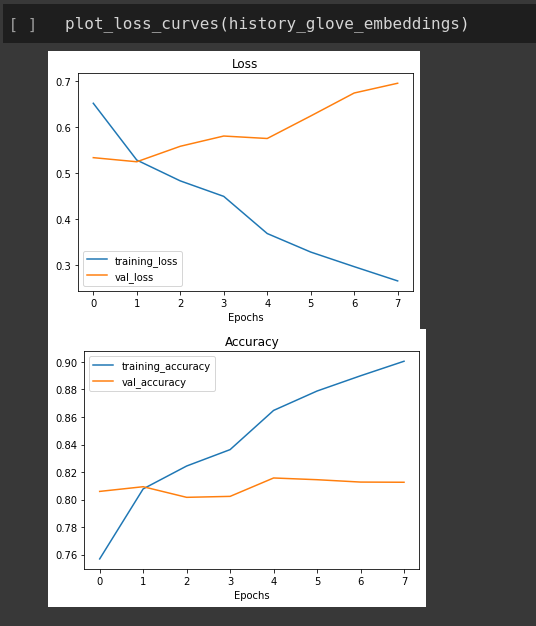


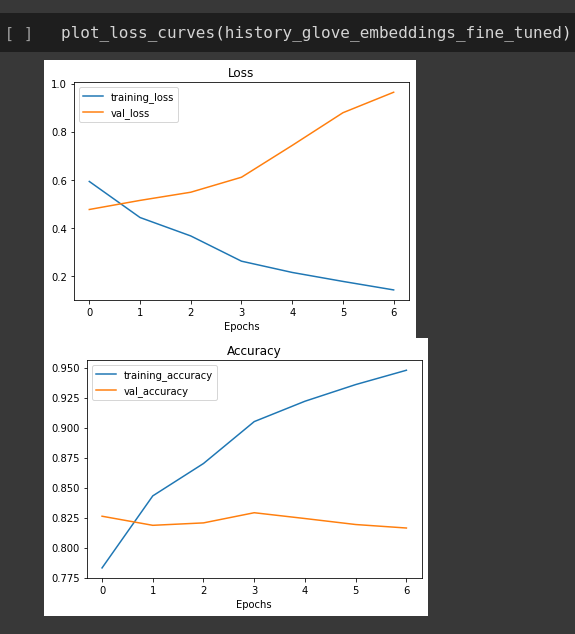


### After

> Not possible as the text are very big/lengthy to one-hot



In [132]:
# train_sen_vectors_one_hot= one_hot_encoder.fit_transform(train_df['text'].to_numpy().reshape(-1,1))
# val_sen_vectors_one_hot= one_hot_encoder.fit_transform(val_df['text'].to_numpy().reshape(-1,1))

# train_sen_vectors_one_hot[0], train_sen_vectors_one_hot.shape

### Training and validation dataset 

In [133]:
train_labels_encoder

array([3, 2, 2, ..., 4, 1, 1])

In [134]:
# train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors_one_hot , train_labels_encoder))
# val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors_one_hot , val_labels_encoder))


train_ds = tf.data.Dataset.from_tensor_slices((train_sen_vectors , train_labels_encoder))
val_ds = tf.data.Dataset.from_tensor_slices((val_sen_vectors , val_labels_encoder))

train_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(55,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Applying the batch size and prefetching (performance optimization)

In [135]:
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [136]:
train_ds,  val_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 55), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 55), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [137]:
train_sen_vectors[0].shape

(55,)

## Glove Embeddings Model with feature extraction model, `trainable=False`.


### Before `L2 Regularizers`

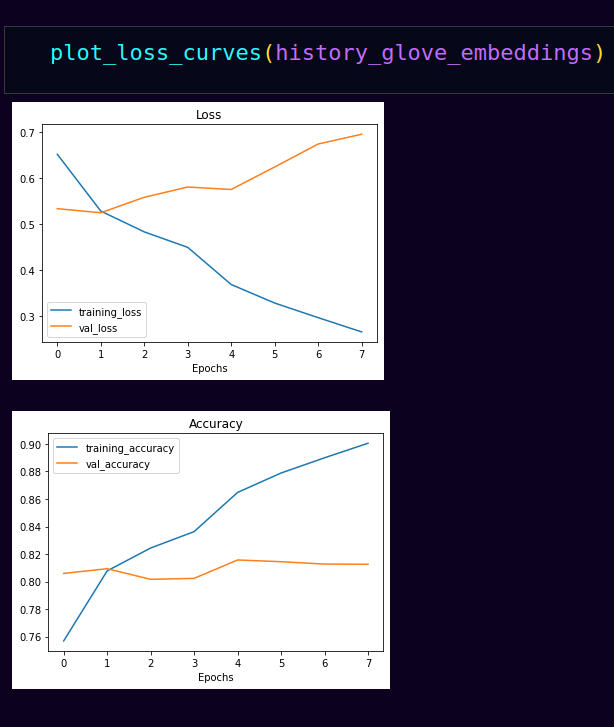


### After, with only L2 Regularizer

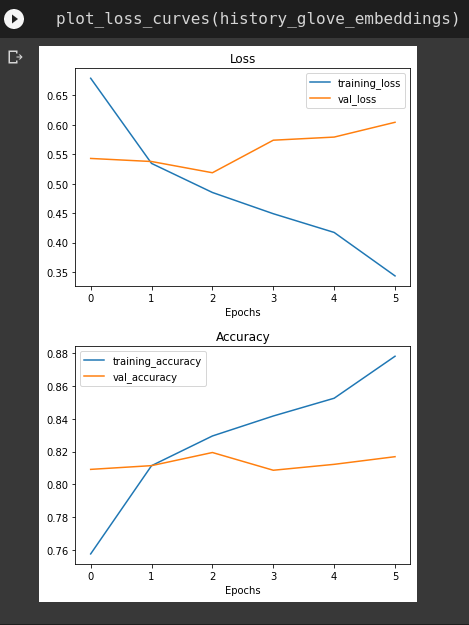



#### After Adding both L1 and L2 Regularizers

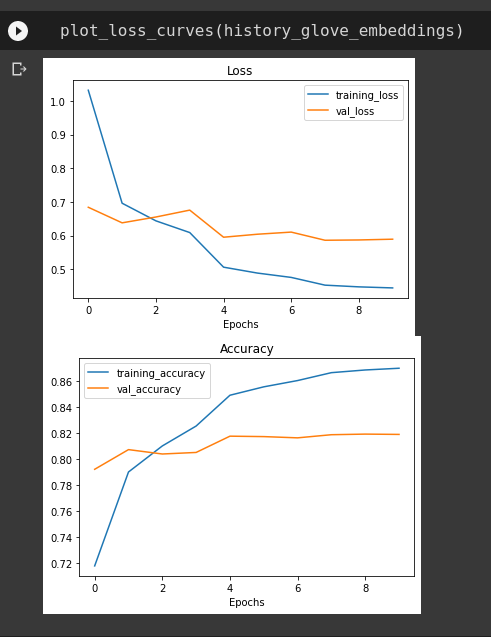



In [138]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer(input)
#sample_emb = embedding_layer(sample_tokens)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dense(128, activation="relu", kernel_regularizer= tf.keras.regularizers.L2(0.001))(x)
x = layers.Dense(128, activation="relu", kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax', kernel_regularizer= tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)

glove_model = tf.keras.Model(input , output, name="glove_embeddings")
glove_model.summary()

Model: "glove_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         6484300   
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 128)        0         
 1D)                                              

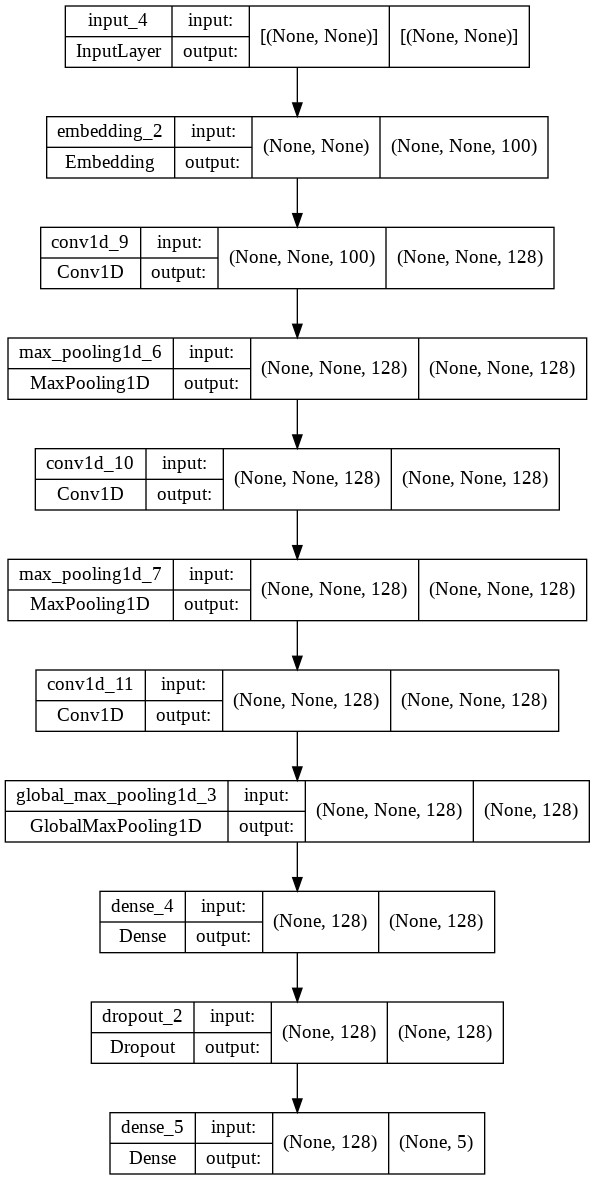

In [139]:
plot_model(glove_model, show_shapes=True)

### Callbacks for Glove Embeddings model

In [140]:
model_checkpoint_path= 'checkpoints_glove_embedding_model'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="glove_embeddings_model")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/glove_embeddings_model/20220902-071627


In [141]:
glove_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ['accuracy'])

history_glove_embeddings=glove_model.fit(train_ds, epochs = 10, steps_per_epoch=len(train_ds),validation_data = val_ds, validation_steps=len(val_ds),callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5624/5627 [============================>.] - ETA: 0s - loss: 1.0306 - accuracy: 0.7164
Epoch 1: val_accuracy improved from -inf to 0.79111, saving model to checkpoints_glove_embedding_model
5627/5627 [==============================] - 26s 5ms/step - loss: 1.0305 - accuracy: 0.7165 - val_loss: 0.6685 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 2/10
5623/5627 [============================>.] - ETA: 0s - loss: 0.6963 - accuracy: 0.7884
Epoch 2: val_accuracy improved from 0.79111 to 0.80051, saving model to checkpoints_glove_embedding_model
5627/5627 [==============================] - 25s 5ms/step - loss: 0.6963 - accuracy: 0.7884 - val_loss: 0.6601 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 3/10
5619/5627 [============================>.] - ETA: 0s - loss: 0.6437 - accuracy: 0.8090
Epoch 3: val_accuracy improved from 0.80051 to 0.80061, saving model to checkpoints_glove_embedding_model
5627/5627 [==============================] - 25s 5ms/step - loss: 0.6437 - accuracy: 0.8090 - val

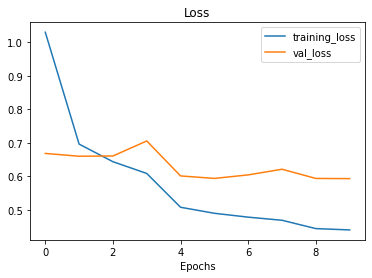

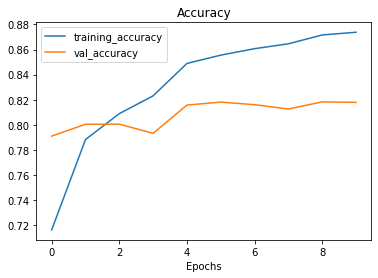

In [145]:
plot_loss_curves(history_glove_embeddings)

In [146]:
glove_embeddings_feature_extractor_pred_probs= glove_model.predict(val_ds)
glove_embeddings_feature_extractor_preds= tf.argmax(glove_embeddings_feature_extractor_pred_probs, axis=1)
glove_embeddings_feature_extractor_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 3, ..., 4, 4, 1])>

In [147]:
glove_embeddings_feature_extractor_results= calculate_results(glove_embeddings_feature_extractor_preds, val_labels_encoder)
glove_embeddings_feature_extractor_results

{'accuracy': 81.79531312061432,
 'precision': 0.8291076518815699,
 'recall': 0.8179531312061432,
 'f1': 0.8204137371153005}

## Glove Embeddings with Feature Extraction model using `SGD()`

In [ ]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer(input)
#sample_emb = embedding_layer(sample_tokens)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

glove_model_using_sgd = tf.keras.Model(input , output)

In [ ]:
glove_model_using_sgd.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         6484300   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

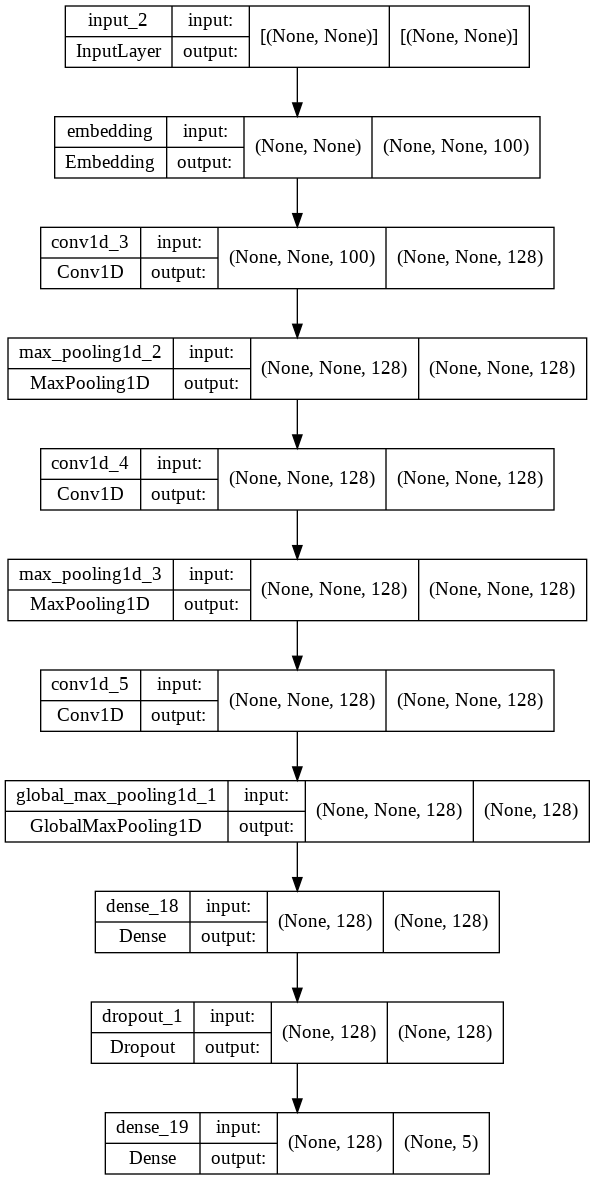

In [ ]:
plot_model(glove_model_using_sgd, show_shapes=True)

### Callbacks for Glove Embeddings model

In [ ]:
model_checkpoint_path= 'checkpoints_glove_embedding_model_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="glove_embeddings_model_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/glove_embeddings_model_using_sgd/20220901-130833


In [ ]:
glove_model_using_sgd.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.SGD(), 
                     metrics = ['accuracy'])

history_glove_embeddings_using_sgd=glove_model_using_sgd.fit(train_ds, epochs = 10, steps_per_epoch=len(train_ds),validation_data = val_ds, validation_steps=len(val_ds),callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5623/5627 [============================>.] - ETA: 0s - loss: 0.8905 - accuracy: 0.6448
Epoch 1: val_accuracy improved from -inf to 0.75271, saving model to checkpoints_glove_embedding_model_using_sgd
5627/5627 [==============================] - 25s 4ms/step - loss: 0.8905 - accuracy: 0.6448 - val_loss: 0.6602 - val_accuracy: 0.7527 - lr: 0.0100
Epoch 2/10
5617/5627 [============================>.] - ETA: 0s - loss: 0.6486 - accuracy: 0.7621
Epoch 2: val_accuracy improved from 0.75271 to 0.78158, saving model to checkpoints_glove_embedding_model_using_sgd
5627/5627 [==============================] - 24s 4ms/step - loss: 0.6486 - accuracy: 0.7621 - val_loss: 0.5922 - val_accuracy: 0.7816 - lr: 0.0100
Epoch 3/10
5615/5627 [============================>.] - ETA: 0s - loss: 0.5811 - accuracy: 0.7897
Epoch 3: val_accuracy improved from 0.78158 to 0.78174, saving model to checkpoints_glove_embedding_model_using_sgd
5627/5627 [==============================] - 24s 4ms/step - loss: 0

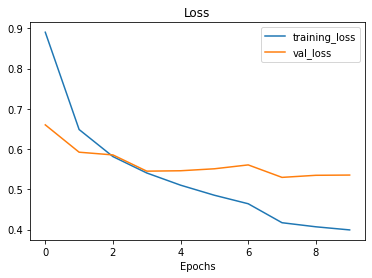

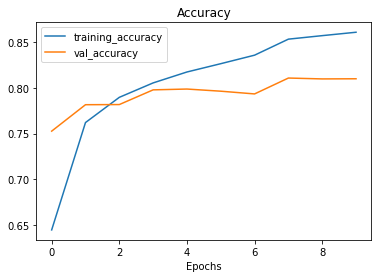

In [ ]:
plot_loss_curves(history_glove_embeddings_using_sgd)

In [ ]:
glove_embeddings_feature_extractor_using_sgd_pred_probs= glove_model_using_sgd.predict(val_ds)
glove_embeddings_feature_extractor_using_sgd_preds= tf.argmax(glove_embeddings_feature_extractor_using_sgd_pred_probs, axis=1)
glove_embeddings_feature_extractor_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
glove_embeddings_feature_extractor_using_sgd_results= calculate_results(glove_embeddings_feature_extractor_preds, val_labels_encoder)
glove_embeddings_feature_extractor_using_sgd_results

{'accuracy': 81.25579240037072,
 'precision': 0.8198473229513495,
 'recall': 0.8125579240037072,
 'f1': 0.8141222548764441}

In [ ]:
glove_embeddings_feature_extractor_results

{'accuracy': 81.25579240037072,
 'precision': 0.8198473229513495,
 'recall': 0.8125579240037072,
 'f1': 0.8141222548764441}

## Glove Embeddings Model with Fine-Tuned model, `trainable=True`.

In [ ]:
sen_embedding_layer_trainable = Embedding(num_tokens_text , embedding_dim , embeddings_initializer = tf.keras.initializers.Constant(sentence_embedding_matrix) , trainable = True)

In [ ]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer_trainable(input)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

glove_model_trainable = tf.keras.Model(input , output)

In [ ]:
glove_model_trainable.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         6484300   
                                                                 
 conv1d_6 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

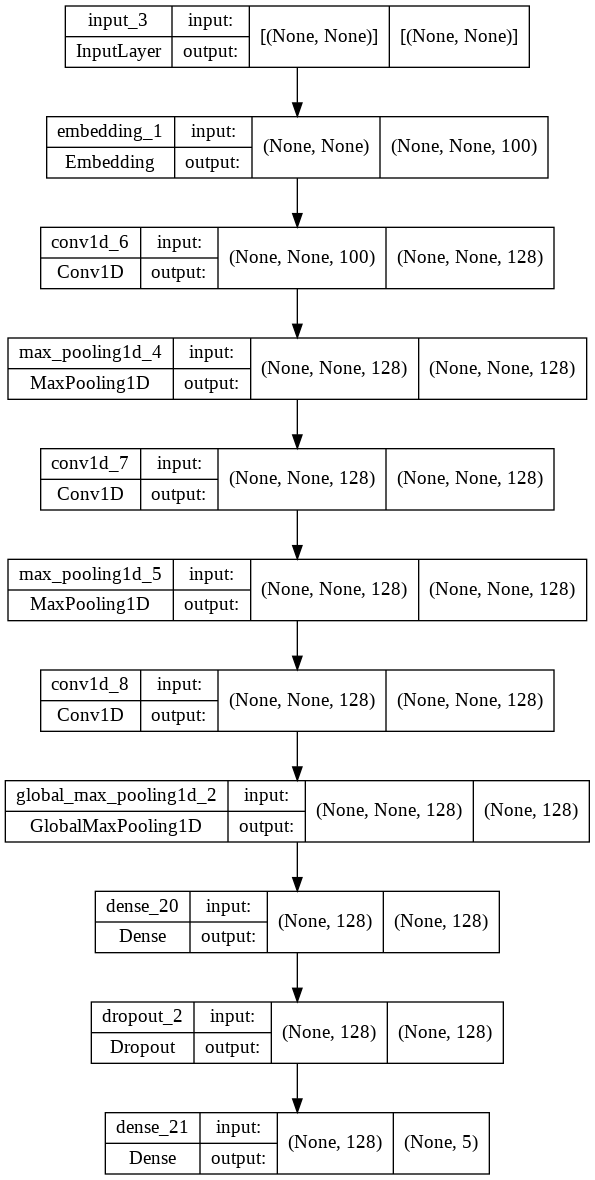

In [ ]:
plot_model(glove_model_trainable, show_shapes=True)

### Callbacks for glove embeddings with Fine-Tuned Model

In [ ]:
model_checkpoint_path= 'checkpoints_glove_embedding_model_fine_tuned'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="glove_embeddings_model_fine_tuned")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/glove_embeddings_model_fine_tuned/20220901-131424


### Training the glove embeddings fine-tuned model

In [ ]:
glove_model_trainable.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics = ['accuracy'])

history_glove_embeddings_fine_tuned=glove_model_trainable.fit(train_ds, epochs = 10, steps_per_epoch=len(train_ds),validation_data = val_ds, validation_steps=len(val_ds),callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.7831
Epoch 1: val_accuracy improved from -inf to 0.82613, saving model to checkpoints_glove_embedding_model_fine_tuned
5627/5627 [==============================] - 45s 8ms/step - loss: 0.5926 - accuracy: 0.7831 - val_loss: 0.4758 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 2/10
5622/5627 [============================>.] - ETA: 0s - loss: 0.4424 - accuracy: 0.8431
Epoch 2: val_accuracy did not improve from 0.82613
5627/5627 [==============================] - 44s 8ms/step - loss: 0.4424 - accuracy: 0.8431 - val_loss: 0.5137 - val_accuracy: 0.8185 - lr: 0.0010
Epoch 3/10
5623/5627 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8701
Epoch 3: val_accuracy did not improve from 0.82613

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
5627/5627 [==============================] - 44s 8ms/step - loss: 0.3657 - accuracy: 0.8701 - val_loss: 0.5478 - val_a

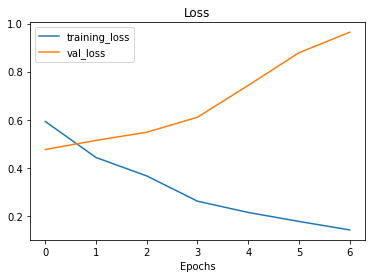

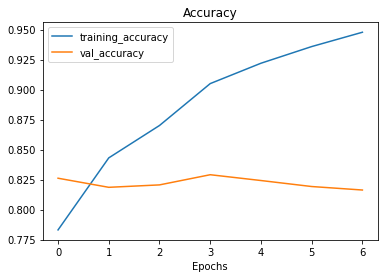

In [ ]:
plot_loss_curves(history_glove_embeddings_fine_tuned)

In [ ]:
glove_embeddings_fine_tuned_pred_probs= glove_model_trainable.predict(val_ds)
glove_embeddings_fine_tuned_preds= tf.argmax(glove_embeddings_fine_tuned_pred_probs, axis=1)
glove_embeddings_fine_tuned_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([4, 0, 3, ..., 4, 1, 1])>

In [ ]:
glove_embeddings_fine_tuned_results= calculate_results(glove_embeddings_fine_tuned_preds, val_labels_encoder)
glove_embeddings_fine_tuned_results

{'accuracy': 81.62981596716537,
 'precision': 0.822352111749879,
 'recall': 0.8162981596716536,
 'f1': 0.8176344277536793}

### Glove Embeddings Model with Fine-Tuned model using `SGD()`, `trainable=True`.

In [ ]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sen_embedding_layer_trainable(input)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

glove_model_trainable_using_sgd = tf.keras.Model(input , output)

In [ ]:
glove_model_trainable_using_sgd.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         6484300   
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

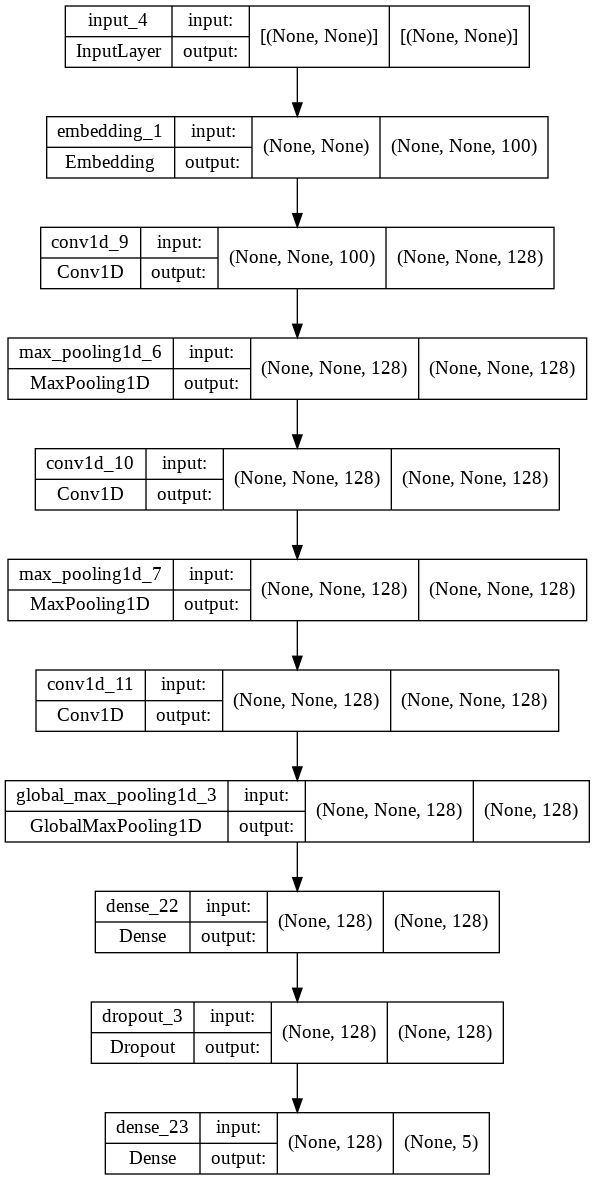

In [ ]:
plot_model(glove_model_trainable_using_sgd, show_shapes=True)

### Callbacks for fine-tuned model using SGD()

In [ ]:
model_checkpoint_path= 'checkpoints_glove_embedding_fine_tuned_model_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="glove_embeddings_fine_tuned_model_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/glove_embeddings_fine_tuned_model_using_sgd/20220901-132056


### Training the glove embeddings fine-tuned model using `SGD()`

In [ ]:
glove_model_trainable_using_sgd.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() , 
                     optimizer = tf.keras.optimizers.SGD(), 
                     metrics = ['accuracy'])

history_glove_embeddings_fine_tuned_using_sgd=glove_model_trainable_using_sgd.fit(train_ds, epochs = 10, steps_per_epoch=len(train_ds),validation_data = val_ds, validation_steps=len(val_ds), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.7657
Epoch 1: val_accuracy improved from -inf to 0.79581, saving model to checkpoints_glove_embedding_fine_tuned_model_using_sgd
5627/5627 [==============================] - 26s 5ms/step - loss: 0.6192 - accuracy: 0.7657 - val_loss: 0.5553 - val_accuracy: 0.7958 - lr: 0.0100
Epoch 2/10
5622/5627 [============================>.] - ETA: 0s - loss: 0.4279 - accuracy: 0.8493
Epoch 2: val_accuracy improved from 0.79581 to 0.81094, saving model to checkpoints_glove_embedding_fine_tuned_model_using_sgd
5627/5627 [==============================] - 25s 4ms/step - loss: 0.4279 - accuracy: 0.8493 - val_loss: 0.5288 - val_accuracy: 0.8109 - lr: 0.0100
Epoch 3/10
5621/5627 [============================>.] - ETA: 0s - loss: 0.3821 - accuracy: 0.8667
Epoch 3: val_accuracy improved from 0.81094 to 0.81448, saving model to checkpoints_glove_embedding_fine_tuned_model_using_sgd
5627/5627 [=======================

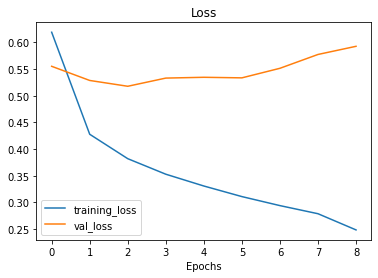

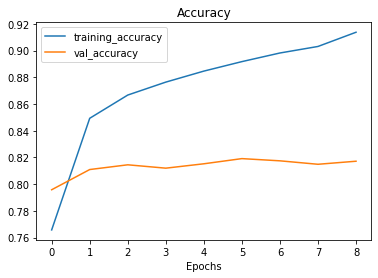

In [ ]:
plot_loss_curves(history_glove_embeddings_fine_tuned_using_sgd)

In [ ]:
glove_embeddings_fine_tuned_using_sgd_pred_probs= glove_model_trainable_using_sgd.predict(val_ds)
glove_embeddings_fine_tuned_using_sgd_preds= tf.argmax(glove_embeddings_fine_tuned_using_sgd_pred_probs, axis=1)
glove_embeddings_fine_tuned_using_sgd_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([4, 0, 3, ..., 4, 1, 1])>

In [ ]:
glove_embeddings_fine_tuned_using_sgd_results= calculate_results(glove_embeddings_fine_tuned_using_sgd_preds, val_labels_encoder)
glove_embeddings_fine_tuned_using_sgd_results

{'accuracy': 81.71587448695882,
 'precision': 0.8248306972014394,
 'recall': 0.8171587448695883,
 'f1': 0.8187595699167254}

In [ ]:
glove_embeddings_fine_tuned_results

{'accuracy': 81.62981596716537,
 'precision': 0.822352111749879,
 'recall': 0.8162981596716536,
 'f1': 0.8176344277536793}

## Replacing the Pre-trained `USE` model with `BERT PubMed Expert` model.

> Both the models are from Tensorflow hub

* Link -> https://tfhub.dev/google/experts/bert/pubmed/2

> Have to Train it on `10%` of the training dataset and `10%` on the validation dataset, otherwise it will take too long to train a single epoch of the model, which will take aroung `30mins` for each epoch. Just to save time and make it easier, I trained on `10%` of the dataset and colab will also disconnect if I train on the whole dataset.

> The evaluation of the model was done on `100%` of the validation dataset


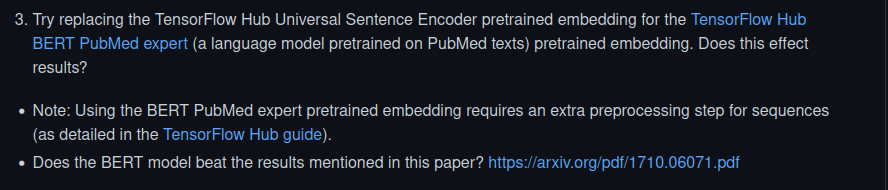

In [53]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import tensorflow_text as text  # Imports TF ops for preprocessing.

### Model Link

In [55]:
model_url='https://tfhub.dev/google/experts/bert/pubmed/2'

### Bert Expert Pubmed Model with `trainable=False`

In [56]:
preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', trainable = False , name = 'pubmed_bert_preprocessor')
preprocessing_layer

In [57]:
bert_expert_pubmed_layer= hub.KerasLayer(model_url, trainable=False, name="bert_expert_pubmed_layer")
bert_expert_pubmed_layer

In [58]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer(inputs)
bert_embedding= bert_expert_pubmed_layer(bert_inputs)
x=layers.Dense(128, activation='relu')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax')(x)

bert_model= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer")

In [59]:
print(f'bert embedding shape: {bert_embedding}')
bert_embedding['pooled_output']

bert embedding shape: {'default': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, 'pooled_output': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, 'sequence_output': <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, 'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>, <KerasTensor: shape=(None, 12

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_expert_pubmed_layer')>

In [60]:
bert_model.summary()

Model: "bert_expert_pubmed_layer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_mask': (Non  0          ['input_sentences[0][0]']        
 sLayer)                        e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                               

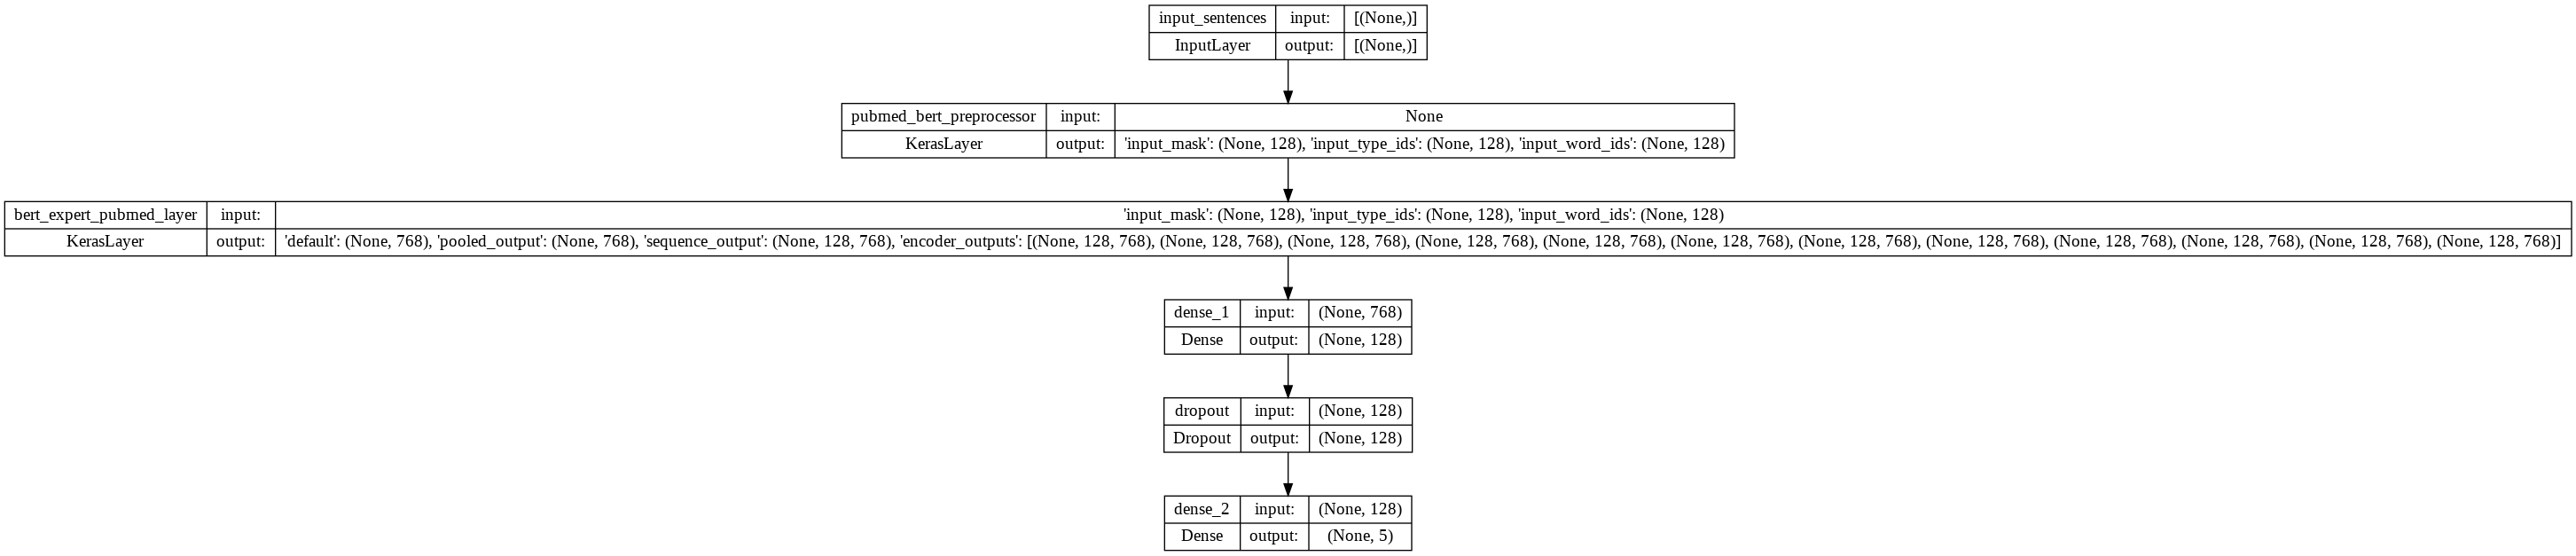

In [61]:
plot_model(bert_model, show_shapes=True)

### Bert Pubmed model datasets

In [62]:
train_sen_ds= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoder))
val_sen_ds= tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoder))

train_sen_ds= train_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_sen_ds= val_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [63]:
train_sen_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Callbacks for Bert Model

In [64]:
model_checkpoint_path= 'checkpoints_bert_model'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model/20220902-141254


In [65]:
bert_model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_bert_model= bert_model.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.7747
Epoch 1: val_accuracy improved from -inf to 0.84209, saving model to checkpoints_bert_model
562/562 [==============================] - 236s 401ms/step - loss: 0.6573 - accuracy: 0.7747 - val_loss: 0.4486 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.5205 - accuracy: 0.8201
Epoch 2: val_accuracy did not improve from 0.84209
562/562 [==============================] - 233s 414ms/step - loss: 0.5205 - accuracy: 0.8201 - val_loss: 0.4413 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.4946 - accuracy: 0.8290
Epoch 3: val_accuracy improved from 0.84209 to 0.85572, saving model to checkpoints_bert_model
562/562 [==============================] - 229s 407ms/step - loss: 0.4946 - accuracy: 0.8290 - val_loss: 0.4198 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 4/10
562/562 [==========

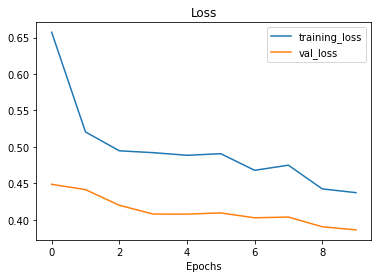

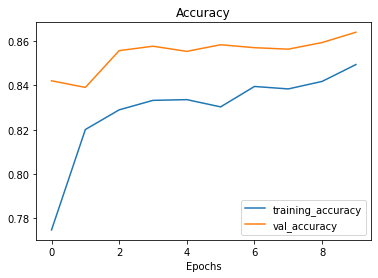

In [66]:
plot_loss_curves(history_bert_model)

In [67]:
bert_model_pred_probs= bert_model.predict(val_sen_ds)
bert_model_preds= tf.argmax(bert_model_pred_probs, axis=1)
bert_model_preds

945/945 [==============================] - 325s 343ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 0, ..., 4, 1, 1])>

In [70]:
bert_model_results= calculate_results(bert_model_preds, val_labels_encoder)
bert_model_results

{'accuracy': 86.4159936449093,
 'precision': 0.8723540523839056,
 'recall': 0.8641599364490931,
 'f1': 0.8662391034396363}

## Bert Expert Pubmed Model using `SGD()` with `trainable=False`

In [73]:
model_checkpoint_path= 'checkpoints_bert_model_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

Saving TensorBoard log files to: tensorboard/bert_model_using_sgd/20220902-145824


In [74]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer(inputs)
bert_embedding= bert_expert_pubmed_layer(bert_inputs)
x=layers.Dense(128, activation='relu')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax')(x)

bert_model_using_sgd= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_using_sgd")

In [75]:
bert_model_using_sgd.summary()

Model: "bert_expert_pubmed_layer_using_sgd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentences (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pubmed_bert_preprocessor (Kera  {'input_mask': (Non  0          ['input_sentences[0][0]']        
 sLayer)                        e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                     

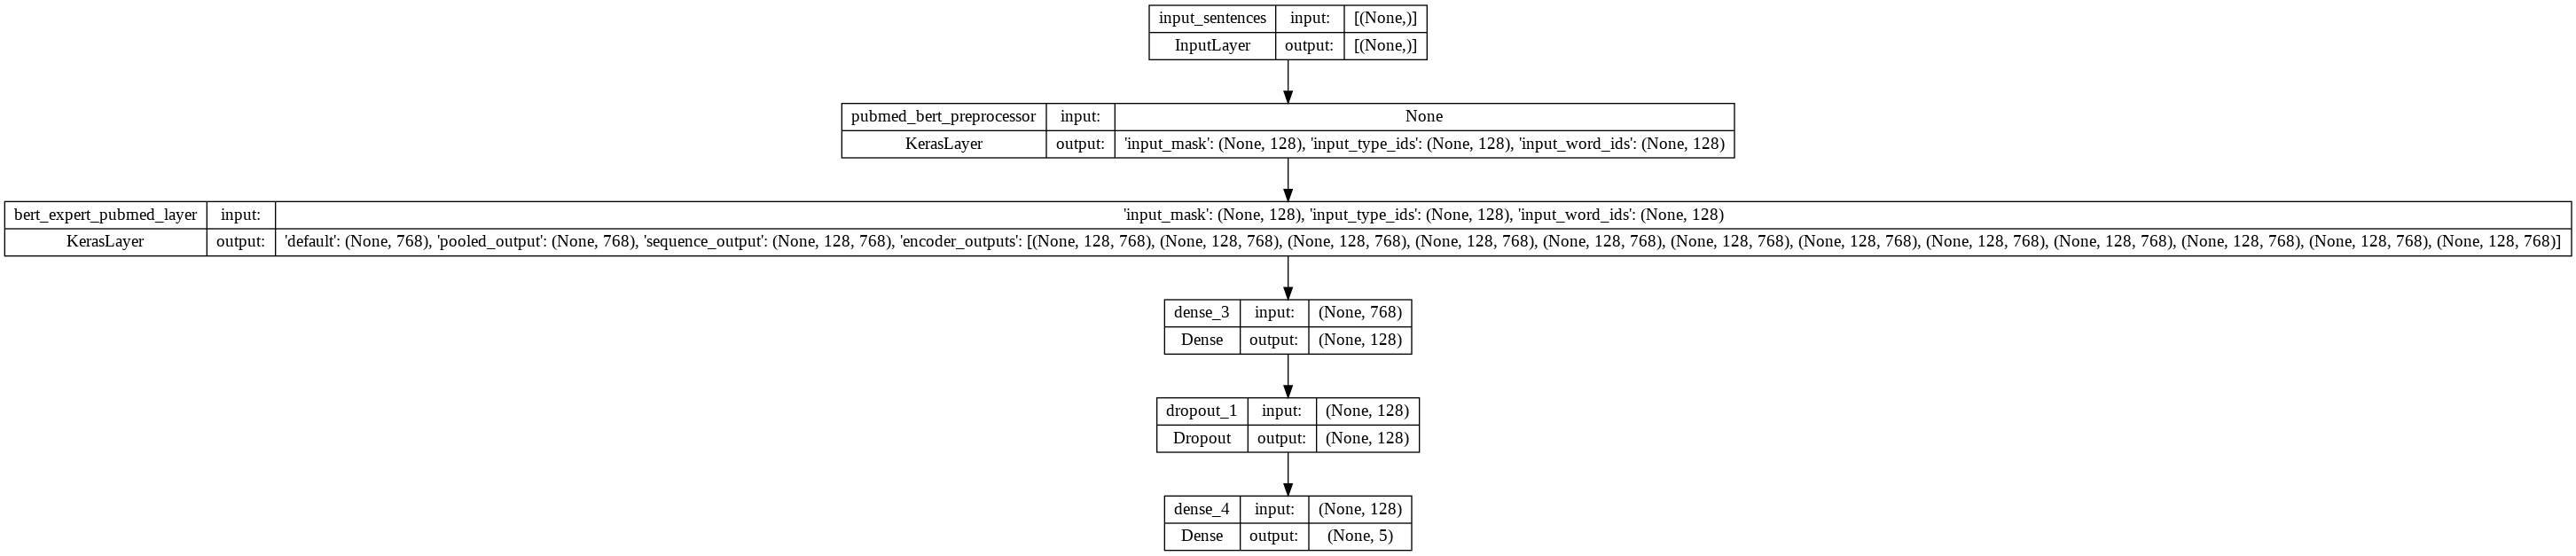

In [76]:
plot_model(bert_model_using_sgd, show_shapes=True)

In [77]:
bert_model_using_sgd.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.SGD(), metrics=["accuracy"])

history_bert_model_using_sgd= bert_model_using_sgd.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.8609 - accuracy: 0.6980
Epoch 1: val_accuracy improved from -inf to 0.81516, saving model to checkpoints_bert_model_using_sgd
562/562 [==============================] - 231s 407ms/step - loss: 0.8609 - accuracy: 0.6980 - val_loss: 0.5630 - val_accuracy: 0.8152 - lr: 0.0100
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.7974
Epoch 2: val_accuracy improved from 0.81516 to 0.83677, saving model to checkpoints_bert_model_using_sgd
562/562 [==============================] - 228s 406ms/step - loss: 0.6104 - accuracy: 0.7974 - val_loss: 0.4849 - val_accuracy: 0.8368 - lr: 0.0100
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.8124
Epoch 3: val_accuracy improved from 0.83677 to 0.84142, saving model to checkpoints_bert_model_using_sgd
562/562 [==============================] - 228s 407ms/step - loss: 0.5451 - accuracy: 0.8124 - val_loss:

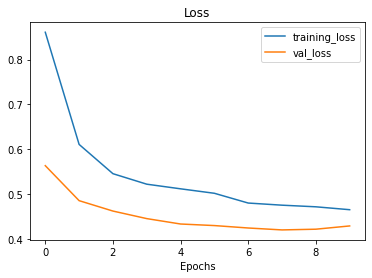

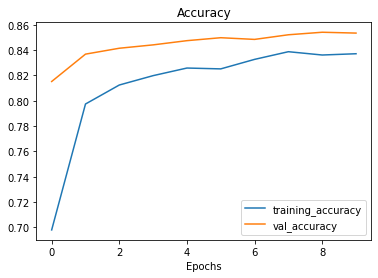

In [78]:
plot_loss_curves(history_bert_model_using_sgd)

In [81]:
bert_model_using_sgd_pred_probs= bert_model_using_sgd.predict(val_sen_ds)
bert_model_using_sgd_preds= tf.argmax(bert_model_using_sgd_pred_probs, axis=1)
bert_model_using_sgd_preds

945/945 [==============================] - 325s 344ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 0, ..., 4, 1, 1])>

In [82]:
bert_model_using_sgd_results= calculate_results(bert_model_using_sgd_preds, val_labels_encoder)
bert_model_using_sgd_results

{'accuracy': 85.11518601880049,
 'precision': 0.8576427614178972,
 'recall': 0.8511518601880048,
 'f1': 0.8531667751737386}

## Bert Expert Pubmed Model with `trainable=True`

In [ ]:
preprocessing_layer_trainable = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', trainable = True , name = 'pubmed_bert_preprocessor_trainable')
preprocessing_layer_trainable

In [ ]:
bert_expert_pubmed_layer_trainable= hub.KerasLayer(model_url, trainable=True, name="bert_expert_pubmed_layer_trainable")
bert_expert_pubmed_layer_trainable

In [ ]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer_trainable(inputs)
bert_embedding= bert_expert_pubmed_layer_trainable(bert_inputs)
x=layers.Dense(128, activation='relu')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax')(x)

bert_model_trainable= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_trainable")

In [ ]:
bert_model_trainable.summary()

In [ ]:
plot_model(bert_model_trainable, show_shapes=True)

In [ ]:
model_checkpoint_path= 'checkpoints_bert_model_trainable'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_trainable")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

In [ ]:
bert_model_trainable.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_bert_model_trainable= bert_model_trainable.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

In [ ]:
plot_loss_curves(history_bert_model_trainable)

In [ ]:
bert_model_trainable_pred_probs= bert_model_trainable.predict(val_sen_ds)
bert_model_trainable_preds= tf.argmax(bert_model_trainable_pred_probs, axis=1)
bert_model_trainable_preds

In [ ]:
bert_model_trainable_results= calculate_results(bert_model_trainable_preds, val_labels_encoder)
bert_model_trainable_results

## Bert Expert Pubmed Model using `SGD()` with `trainable=True`

In [ ]:
inputs= layers.Input(shape=[], dtype="string", name="input_sentences")
bert_inputs= preprocessing_layer_trainable(inputs)
bert_embedding= bert_expert_pubmed_layer_trainable(bert_inputs)
x=layers.Dense(128, activation='relu')(bert_embedding['pooled_output'])
x=layers.Dropout(0.5)(x)
outputs= layers.Dense(num_classes, activation='softmax')(x)

bert_model_trainable_using_sgd= tf.keras.Model(inputs, outputs, name="bert_expert_pubmed_layer_trainable_using_sgd")

In [ ]:
bert_model_trainable_using_sgd.summary()

In [ ]:
plot_model(bert_model_trainable_using_sgd, show_shapes=True)

In [ ]:
model_checkpoint_path= 'checkpoints_bert_model_trainable_using_sgd'
check_point_callback= model_check_point_callback(model_checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

dir_name= 'tensorboard'
tensorboard_callback= create_tensorboard_callback(dir_name, experiment_name="bert_model_trainable_using_sgd")

early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=3)

reduce_lr_callback= reduce_learning_rate_callback(monitor="val_accuracy", factor=0.2, patience=2, minimum_lr= 1e-7)

In [ ]:
bert_model_trainable_using_sgd.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer= tf.keras.optimizers.SGD(), metrics=["accuracy"])

history_bert_model_trainable_using_sgd= bert_model_trainable_using_sgd.fit(train_sen_ds, epochs=10, steps_per_epoch=int(0.1 * len(train_sen_ds)), validation_data=val_sen_ds, validation_steps=int(0.1* len(val_sen_ds)), callbacks=[tensorboard_callback, check_point_callback, early_stopping_callback, reduce_lr_callback])

In [ ]:
plot_loss_curves(history_bert_model_trainable_using_sgd)

In [ ]:
bert_model_trainable_using_sgd_pred_probs= bert_model_trainable_using_sgd.predict(val_sen_ds)
bert_model_trainable_using_sgd_preds= tf.argmax(bert_model_trainable_using_sgd_pred_probs, axis=1)
bert_model_trainable_using_sgd_preds

In [ ]:
bert_model_trainable_using_sgd_results= calculate_results(bert_model_trainable_using_sgd_preds, val_labels_encoder)
bert_model_trainable_using_sgd_results